### Library

In [85]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import plotly.graph_objs as go
from torch_geometric.data import Data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Dataset, Data
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt



### Data Read

In [86]:
data_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/Kinect_data_S0-S104_raw_2025-04-17_13-31PM.csv"

dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]

clinical_data = pd.read_csv("/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Clinical Data/AIFrailtyCaseReportF_DATA_2025-04-15_1354.csv")
clinical_data.rename(columns={'record_id': 'patientID'}, inplace=True)



In [87]:
# Ensure patientID column exists in both DataFrames
# Merge QoR_class into clinical_data based on patientID
dataframe = dataframe.merge(clinical_data[['patientID', 'qor15_score']], on='patientID', how='left')

/home/iqh4001/.conda/envs/jupyter-notebook/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


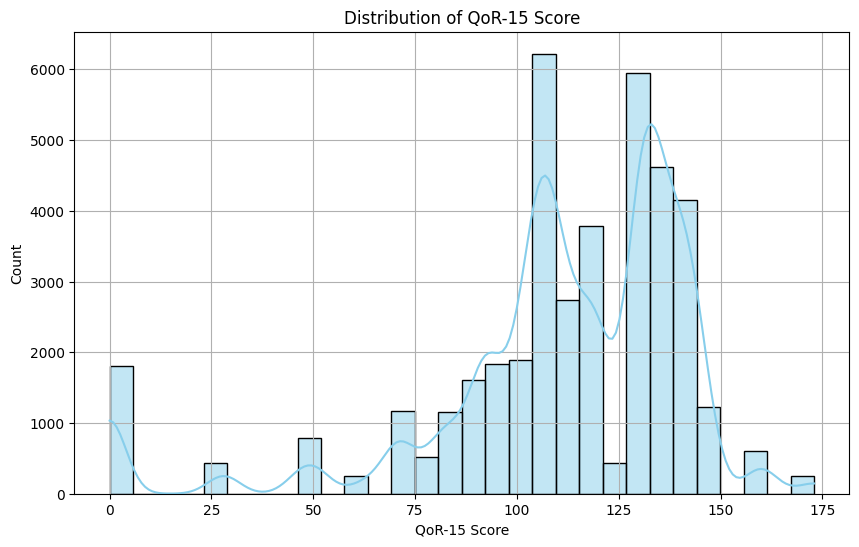

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace 'dataframe' with your actual DataFrame variable
plt.figure(figsize=(10, 6))
sns.histplot(data=dataframe, x='qor15_score', bins=30, kde=True, color='skyblue')

plt.title('Distribution of QoR-15 Score')
plt.xlabel('QoR-15 Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()


In [89]:
dataframe = dataframe.dropna(subset=['qor15_score'])

In [90]:
dataframe.reset_index(drop=True, inplace=True)

In [91]:
dataframe['qor15_score']
dataframe['qor15_score'].unique()
dataframe['qor15_score'].value_counts()

qor15_score
135.0    1996
105.0    1982
132.0    1924
0.0      1800
130.0    1785
120.0    1578
143.0    1557
108.0    1513
138.0    1366
111.0    1354
107.0    1287
140.0    1246
131.0    1215
71.0     1173
93.0     1074
133.0     993
100.0     990
118.0     966
92.0      959
102.0     899
83.0      844
106.0     834
129.0     822
145.0     804
119.0     714
141.0     706
90.0      646
142.0     644
160.0     606
112.0     558
79.0      513
113.0     442
28.0      435
94.0      421
147.0     416
51.0      415
104.0     413
114.0     392
47.0      376
98.0      333
85.0      308
117.0     269
134.0     266
126.0     260
116.0     258
63.0      250
173.0     249
128.0     208
109.0     192
124.0     172
Name: count, dtype: int64

In [92]:

conditions = [
    (dataframe['qor15_score'] > 5) & (dataframe['qor15_score'] <= 120),
    (dataframe['qor15_score'] >= 125) & (dataframe['qor15_score'] <= 150)
]

values = [1,0]  # 1 = 'Not Good', 0 = 'Good'

dataframe['QoR_class'] = np.select(conditions, values,default=np.nan)



In [93]:
dataframe['patientID'].unique()
dataframe['patientID'].value_counts()


patientID
089-JH    1982
067-MT    1173
087-DO    1120
070-TC    1094
037-MA    1021
          ... 
006-TR     192
005-GP     172
047-MW     150
016-GE     147
041-JL      77
Name: count, Length: 75, dtype: int64

In [94]:
dataframe['QoR_class']
dataframe['QoR_class'].unique()
dataframe['QoR_class'].value_counts(dropna=False)

QoR_class
1.0    22388
0.0    16208
NaN     2827
Name: count, dtype: int64

In [95]:
dataframe = dataframe.dropna(subset=['QoR_class'])

In [96]:
dataframe.reset_index(drop=True, inplace=True)

In [97]:
from datetime import datetime

# Create timestamp
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M%p")

# Construct filename with timestamp
filename = f"Kinect_data_with_Valid_QoR_class_{timestamp}.csv"

# Define full save path
save_path = f"/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/{filename}"

# Save DataFrame
dataframe.to_csv(save_path, index=False)

print(f"DataFrame saved to:\n{save_path}")


KeyboardInterrupt: 

In [ ]:
dataframe = pd.read_csv("/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/Kinect_data_with_Valid_QoR_class_2025-04-17_16-25PM.csv")

### CNN

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd


#dataframe = pd.read_csv("/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/Kinect_feature_matrix_20240918_163843.csv") 
dataframe = pd.read_csv("/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/Kinect_data_with_Valid_QoR_class_2025-04-17_13-37PM.csv") 


X = dataframe.drop(columns=['QoR_class', 'patientID', 'trial_num', 'walking_speed'])  
y = dataframe['QoR_class'] 
groups = dataframe['patientID'] 


gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Step 2: Convert Data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32    #Window Size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class SimpleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]  # Number of features
hidden_size = 128  # Example hidden size
output_size = len(y.unique())  # Number of classes
model = SimpleModel(input_size, hidden_size, output_size)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 4: Training Loop
epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

# Save the model after training
torch.save(model.state_dict(), 'QOR_classification_model.pth')
print("Model saved successfully!")

# Final Test Accuracy
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')


### Cross Validation

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import GroupKFold
import pandas as pd
import numpy as np

# Load the data
dataframe = pd.read_csv("/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/Kinect_data_with_Valid_QoR_class_2025-04-17_13-37PM.csv") 
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']

X = dataframe.drop(columns=['QoR_class', 'patientID', 'trial_num', 'walking_speed'])
y = dataframe['QoR_class']
groups = dataframe['patientID']

# Convert to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

class SimpleModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X.shape[1]
hidden_size = 128
output_size = len(y.unique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

kf = GroupKFold(n_splits=5)
fold = 1

for train_idx, test_idx in kf.split(X, y, groups):
    print(f"\n===== Fold {fold} =====")
    train_dataset = Subset(dataset, train_idx)
    test_dataset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = SimpleModel(input_size, hidden_size, output_size).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 30
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train, total_train = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += y_batch.size(0)
            correct_train += (predicted == y_batch).sum().item()

        train_acc = 100 * correct_train / total_train

        model.eval()
        test_loss = 0
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_test += y_batch.size(0)
                correct_test += (predicted == y_batch).sum().item()

        test_acc = 100 * correct_test / total_test
        print(f"Epoch {epoch+1:02d}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    fold += 1


#### Training & testing accuracy curve over epoch

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, len(train_accuracies) + 1)

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16)
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16)
plt.legend()
plt.show()

#### Perforamce Evaluation Plots

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Function to Evaluate the Model
def evaluate_model(loader, dataset_name="Test"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            
            loss = criterion(out, y_batch)
            total_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(out, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_logits.extend(out[:, 1].cpu().numpy())

    # Compute metrics
    avg_loss = total_loss / total
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    roc_auc = roc_auc_score(all_labels, all_logits)
    
    # Compute specificity
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n📊 {dataset_name} Evaluation Results:")
    print(f"✅ Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ ROC-AUC: {roc_auc:.4f}")

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = np.nan_to_num(conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100)

    # Debugging: Print Confusion Matrix Values
    print("Confusion Matrix (Raw Counts):\n", conf_matrix)
    print("Confusion Matrix (Percentage):\n", conf_matrix_percentage)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(conf_matrix_percentage, annot=False, fmt='.2f', cmap='plasma', linewidths=0.5,
                     xticklabels=['Non-Frail (0)', 'Frail (1)'],
                     yticklabels=['Non-Frail (0)', 'Frail (1)'], cbar=False)

    # Manually add annotations to force visibility
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            text_value = f"{conf_matrix_percentage[i, j]:.2f}%"
            text_color = "black" if conf_matrix_percentage[i, j] > 50 else "white"
            ax.text(j + 0.5, i + 0.5, text_value, 
                    ha='center', va='center', fontsize=14, fontweight='bold', color=text_color)

    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
    plt.ylabel('True Labels', fontsize=14, fontweight='bold')

    # Explicitly set ticks to ensure row visibility
    plt.xticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')
    plt.yticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')

    plt.show()


    return avg_loss, accuracy, precision, recall, f1, specificity, roc_auc, np.array(all_labels), np.array(all_logits)

# Evaluate on Training and Test Data
train_metrics = evaluate_model(train_loader, "Training")
test_metrics = evaluate_model(test_loader, "Testing")

# Plot Training & Testing ROC Curve
plt.figure(figsize=(6, 5))
train_fpr, train_tpr, _ = roc_curve(train_metrics[7], train_metrics[8])
test_fpr, test_tpr, _ = roc_curve(test_metrics[7], test_metrics[8])
plt.plot(train_fpr, train_tpr, color='blue', linewidth=2, label=f'Training ROC (AUC = {train_metrics[6]:.4f})')
plt.plot(test_fpr, test_tpr, color='red', linewidth=2, label=f'Testing ROC (AUC = {test_metrics[6]:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Training vs. Testing ROC Curve', fontsize=16, fontweight='bold')
plt.show()

# Plot Class-wise ROC Curve for Training Data
plt.figure(figsize=(6, 5))
for i, label in enumerate(['Non-Frail (0)', 'Frail (1)']):
    fpr, tpr, _ = roc_curve((train_metrics[7] == i).astype(int), train_metrics[8])
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Training ROC Curve for Each Class', fontsize=16, fontweight='bold')
plt.show()

# Plot Class-wise ROC Curve for Testing Data
plt.figure(figsize=(6, 5))
for i, label in enumerate(['Non-Frail (0)', 'Frail (1)']):
    fpr, tpr, _ = roc_curve((test_metrics[7] == i).astype(int), test_metrics[8])
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Testing ROC Curve for Each Class', fontsize=16, fontweight='bold')
plt.show()


### LSTM

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
#data_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/QOR_class_Kinect_feature_matrix_20241028_171716.csv"
#dataframe = pd.read_csv(data_path)

# Prepare data
X = dataframe.drop(columns=['QoR_class', 'patientID', 'trial_num', 'walking_speed'])  
y = dataframe['QoR_class'] 
groups = dataframe['patientID'] 

# Normalize data (standardization)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into train and test using GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model Definition with Dropout and Bidirectional LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last hidden state for classification
        out = out[:, -1, :]
        
        # Fully connected layer
        out = self.fc(out)
        return out

# Model hyperparameters
input_size = X_train.shape[1]  # Number of features (input size)
hidden_size = 64  # Reduced hidden size
output_size = len(y.unique())  # Number of classes
model = LSTMModel(input_size, hidden_size, output_size, num_layers=1)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # L2 Regularization (weight decay)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Early stopping setup
patience = 5
best_test_acc = 0
epochs_without_improvement = 0

# Training Loop
epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))  # Add batch dimension for LSTM
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.unsqueeze(1))  # Add batch dimension for LSTM
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # Early stopping check
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()

# Save the model after training
torch.save(model.state_dict(), 'QOR_classification_lstm.pth')
print("LSTM Model saved successfully!")

# Final Test Accuracy
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')

# Confusion Matrix
all_true_labels = []
all_pred_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch.unsqueeze(1))  # Add batch dimension for LSTM
        _, predicted = torch.max(outputs, 1)
        all_true_labels.extend(y_batch.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())


### Cross Validation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
dataframe = pd.read_csv("/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/Kinect_data_with_Valid_QoR_class_2025-04-17_13-37PM.csv")

# Prepare data
X = dataframe.drop(columns=['QoR_class', 'patientID', 'trial_num', 'walking_speed'])
y = dataframe['QoR_class']
groups = dataframe['patientID']

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

input_size = X_train.shape[1]
hidden_size = 64
output_size = len(y.unique())
model = LSTMModel(input_size, hidden_size, output_size, num_layers=1)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

patience = 5
best_test_acc = 0
epochs_without_improvement = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training
epochs = 100
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = total_train = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Test
    model.eval()
    test_loss = 0
    correct_test = total_test = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()

# Save model
torch.save(model.state_dict(), 'QOR_classification_lstm.pth')
print("LSTM Model saved successfully!")
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')

# Confusion matrix
all_true_labels = []
all_pred_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch.unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        all_true_labels.extend(y_batch.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_true_labels, all_pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Training & testing accuracy curve over epoch

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, len(train_accuracies) + 1)

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16)
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16)
plt.legend()
plt.show()


#### Perforamce Evaluation Plots

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Function to Evaluate the Model and Get ROC Data
def evaluate_model(loader, dataset_name="Test"):
    print(f"\n🚀 Running evaluation for {dataset_name}...")  
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch.unsqueeze(1))  
            
            loss = criterion(out, y_batch)
            total_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(out, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_logits.extend(out[:, 1].cpu().numpy())

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1])

    # Normalize Confusion Matrix
    conf_matrix_percentage = np.nan_to_num(conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(conf_matrix_percentage, annot=False, fmt='.2f', cmap='plasma', linewidths=0.5,
                     xticklabels=['Non-Frail (0)', 'Frail (1)'],
                     yticklabels=['Non-Frail (0)', 'Frail (1)'], cbar=False)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            text_value = f"{conf_matrix_percentage[i, j]:.2f}%"
            text_color = "black" if conf_matrix_percentage[i, j] > 50 else "white"
            ax.text(j + 0.5, i + 0.5, text_value, 
                    ha='center', va='center', fontsize=14, fontweight='bold', color=text_color)

    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
    plt.ylabel('True Labels', fontsize=14, fontweight='bold')
    plt.xticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')
    plt.yticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')

    plt.show()
    
    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_logits)
    roc_auc = roc_auc_score(all_labels, all_logits)

    return total_loss / total, accuracy_score(all_labels, all_preds), precision_score(all_labels, all_preds, zero_division=0), recall_score(all_labels, all_preds), f1_score(all_labels, all_preds), roc_auc, fpr, tpr


# Evaluate on Training and Test Data
train_metrics = evaluate_model(train_loader, "Training")
test_metrics = evaluate_model(test_loader, "Testing")

# Extract ROC Data
train_fpr, train_tpr, train_auc = train_metrics[-2], train_metrics[-1], train_metrics[5]
test_fpr, test_tpr, test_auc = test_metrics[-2], test_metrics[-1], test_metrics[5]

# Plot Training and Testing ROC Curves in the Same Figure
plt.figure(figsize=(6, 5))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Training ROC (AUC = {train_auc:.4f})')
plt.plot(test_fpr, test_tpr, color='red', lw=2, label=f'Testing ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Training vs. Testing ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.show()


### LSTM With Timestamp

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
#dataframe = pd.read_csv(r'C:\Users\RAZER\Desktop\KINZ AGAIN\Kinect_feature_matrix_20250307_123820.csv')

# Prepare data
# Include 'timeStamps' as an additional feature
X = dataframe.drop(columns=['QoR_class', 'patientID', 'trial_num', 'walking_speed'])

# Concatenate 'timeStamps' as an additional column to the X dataset
X = pd.concat([X, dataframe['timeStamps']], axis=1)

y = dataframe['QoR_class']
groups = dataframe['patientID']

# Normalize data (standardization)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into train and test using GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model Definition with Dropout, Bidirectional LSTM, and more layers
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Bidirectional LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last hidden state for classification
        out = out[:, -1, :]
        
        # Fully connected layer
        out = self.fc(out)
        return out

# Model hyperparameters
input_size = X_train.shape[1]  # Now includes 'timeStamps', so input_size should be 102
hidden_size = 128  # Increased hidden size to capture more complex patterns
output_size = len(y.unique())  # Number of classes
model = LSTMModel(input_size, hidden_size, output_size, num_layers=3)  # Increased num_layers

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)  # Lower learning rate and higher weight decay for L2 regularization

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Early stopping setup
patience = 5
best_test_acc = 0
epochs_without_improvement = 0

# Training Loop
epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))  # Add batch dimension for LSTM
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch.unsqueeze(1))  # Add batch dimension for LSTM
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # Early stopping check
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()

# Save the model after training
torch.save(model.state_dict(), 'QOR_classification_lstm_improved.pth')
print("LSTM Model saved successfully!")

# Final Test Accuracy
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')

# Confusion Matrix
all_true_labels = []
all_pred_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch.unsqueeze(1))  # Add batch dimension for LSTM
        _, predicted = torch.max(outputs, 1)
        all_true_labels.extend(y_batch.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())



### Cross Validation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupKFold
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# Load dataset
# dataframe = pd.read_csv(r'C:\Users\RAZER\Desktop\KINZ AGAIN\Kinect_feature_matrix_20250307_123820.csv')

# Prepare data
X = dataframe.drop(columns=['QoR_class', 'patientID', 'trial_num', 'walking_speed'])
X = pd.concat([X, dataframe['timeStamps']], axis=1)
y = dataframe['QoR_class']
groups = dataframe['patientID']

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert full data to tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Cross-validation setup
kf = GroupKFold(n_splits=5)
fold = 1

for train_idx, test_idx in kf.split(X, y, groups):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = LSTMModel(X_train.shape[1], 128, len(y.unique()), num_layers=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_test_acc = 0
    patience = 5
    epochs_without_improvement = 0

    for epoch in range(1, 101):
        model.train()
        total_loss, correct_train, total_train = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_acc = 100 * correct_train / total_train

        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch.unsqueeze(1))
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == y_batch).sum().item()
                total_test += y_batch.size(0)

        test_acc = 100 * correct_test / total_test
        print(f"Epoch {epoch}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    print(f"✅ Best Test Accuracy for Fold {fold}: {best_test_acc:.2f}%")
    fold += 1


#### Training & testing accuracy curve over epoch

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, len(train_accuracies) + 1)

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16)
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16)
plt.legend()
plt.show()


#### Perforamce Evaluation Plots

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Function to Evaluate the Model and Get ROC Data
def evaluate_model(loader, dataset_name="Test"):
    print(f"\n🚀 Running evaluation for {dataset_name}...")  
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch.unsqueeze(1))  
            
            loss = criterion(out, y_batch)
            total_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(out, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_logits.extend(out[:, 1].cpu().numpy())

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1])

    # Normalize Confusion Matrix
    conf_matrix_percentage = np.nan_to_num(conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(conf_matrix_percentage, annot=False, fmt='.2f', cmap='plasma', linewidths=0.5,
                     xticklabels=['Non-Frail (0)', 'Frail (1)'],
                     yticklabels=['Non-Frail (0)', 'Frail (1)'], cbar=False)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            text_value = f"{conf_matrix_percentage[i, j]:.2f}%"
            text_color = "black" if conf_matrix_percentage[i, j] > 50 else "white"
            ax.text(j + 0.5, i + 0.5, text_value, 
                    ha='center', va='center', fontsize=14, fontweight='bold', color=text_color)

    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
    plt.ylabel('True Labels', fontsize=14, fontweight='bold')
    plt.xticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')
    plt.yticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')

    plt.show()
    
    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_logits)
    roc_auc = roc_auc_score(all_labels, all_logits)

    return total_loss / total, accuracy_score(all_labels, all_preds), precision_score(all_labels, all_preds, zero_division=0), recall_score(all_labels, all_preds), f1_score(all_labels, all_preds), roc_auc, fpr, tpr


# Evaluate on Training and Test Data
train_metrics = evaluate_model(train_loader, "Training")
test_metrics = evaluate_model(test_loader, "Testing")

# Extract ROC Data
train_fpr, train_tpr, train_auc = train_metrics[-2], train_metrics[-1], train_metrics[5]
test_fpr, test_tpr, test_auc = test_metrics[-2], test_metrics[-1], test_metrics[5]

# Plot Training and Testing ROC Curves in the Same Figure
plt.figure(figsize=(6, 5))
plt.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Training ROC (AUC = {train_auc:.4f})')
plt.plot(test_fpr, test_tpr, color='red', lw=2, label=f'Testing ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Training vs. Testing ROC Curve', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=12)
plt.show()


### CNN-LSTM Hybrid

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupShuffleSplit
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load dataset
#dataframe = pd.read_csv(r'C:\Users\RAZER\Desktop\KINZ AGAIN\Kinect_feature_matrix_20250307_123820.csv')

# Prepare data
# Include 'timeStamps' as an additional feature
X = dataframe.drop(columns=['QoR_class', 'patientID', 'trial_num', 'walking_speed'])

# Concatenate 'timeStamps' as an additional column to the X dataset
X = pd.concat([X, dataframe['timeStamps']], axis=1)

y = dataframe['QoR_class']
groups = dataframe['patientID']

# Normalize data (standardization)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into train and test using GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN-LSTM Hybrid Model Definition
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.5):
        super(CNNLSTMModel, self).__init__()
        
        # Initialize hidden_size as an attribute of the model
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # CNN Layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # LSTM Layer
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 for bidirectional
        
        # Batch Normalization
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        # Apply CNN layers with Batch Normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        
        # Prepare data for LSTM (must reshape to [batch_size, seq_len, input_size])
        x = x.permute(0, 2, 1)  # Change shape to [batch_size, seq_len, input_size]
        
        # LSTM forward pass
        h0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirectional
        c0 = torch.zeros(2 * self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Use the last hidden state for classification
        out = out[:, -1, :]
        
        # Fully connected layer
        out = self.fc(out)
        return out

# Model hyperparameters
input_size = X_train.shape[1]  # Now includes 'timeStamps', so input_size should be 102
hidden_size = 128  # Increased hidden size to capture more complex patterns
output_size = len(y.unique())  # Number of classes
model = CNNLSTMModel(input_size=1, hidden_size=hidden_size, output_size=output_size, num_layers=3, dropout=0.5)  # Adjusted input_size for CNN

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)  # Lower learning rate and higher weight decay for L2 regularization

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Early stopping setup
patience = 5
best_test_acc = 0
epochs_without_improvement = 0

# Training Loop
epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        # Reshape the data to [batch_size, num_channels, sequence_length]
        X_batch = X_batch.unsqueeze(1)  # Adding channel dimension (1 for single feature per time step)
        
        outputs = model(X_batch)  # Pass through CNN-LSTM model
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Reshape the data to [batch_size, num_channels, sequence_length]
            X_batch = X_batch.unsqueeze(1)  # Adding channel dimension (1 for single feature per time step)
            
            outputs = model(X_batch)  # Pass through CNN-LSTM model
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += y_batch.size(0)
            correct_test += (predicted == y_batch).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_acc = 100 * correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

    # Early stopping check
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

    scheduler.step()

# Save the model after training
torch.save(model.state_dict(), 'QOR_classification_cnn_lstm.pth')
print("CNN-LSTM Model saved successfully!")

# Final Test Accuracy
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')

# Confusion Matrix
all_true_labels = []
all_pred_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Reshape the data to [batch_size, num_channels, sequence_length]
        X_batch = X_batch.unsqueeze(1)  # Adding channel dimension (1 for single feature per time step)
        
        outputs = model(X_batch)  # Pass through CNN-LSTM model
        _, predicted = torch.max(outputs, 1)
        all_true_labels.extend(y_batch.cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())



### Cross Validation

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GroupKFold
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

# Load dataset
# dataframe = pd.read_csv(r'C:\Users\RAZER\Desktop\KINZ AGAIN\Kinect_feature_matrix_20250307_123820.csv')

# Prepare data
X = dataframe.drop(columns=['QoR_class', 'patientID', 'trial_num', 'walking_speed'])
X = pd.concat([X, dataframe['timeStamps']], axis=1)
y = dataframe['QoR_class']
groups = dataframe['patientID']

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert full data to tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        return self.fc(out)

# Cross-validation setup
kf = GroupKFold(n_splits=5)
fold = 1

for train_idx, test_idx in kf.split(X, y, groups):
    print(f"\n===== Fold {fold} =====")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = LSTMModel(X_train.shape[1], 128, len(y.unique()), num_layers=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_test_acc = 0
    patience = 5
    epochs_without_improvement = 0

    for epoch in range(1, 101):
        model.train()
        total_loss, correct_train, total_train = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_acc = 100 * correct_train / total_train

        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch.unsqueeze(1))
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == y_batch).sum().item()
                total_test += y_batch.size(0)

        test_acc = 100 * correct_test / total_test
        print(f"Epoch {epoch}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()

    print(f"✅ Best Test Accuracy for Fold {fold}: {best_test_acc:.2f}%")
    fold += 1


#### Training & testing accuracy curve over epoch

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = range(1, len(train_accuracies) + 1)

# Plot accuracy curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16)
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16)
plt.legend()
plt.show()


#### Perforamce Evaluation Plots

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Function to Evaluate the Model
def evaluate_model(loader, dataset_name="Test"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            X_batch = X_batch.unsqueeze(1)  # Add channel dimension for CNN
            out = model(X_batch)
            
            loss = criterion(out, y_batch)
            total_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(out, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            all_logits.extend(out[:, 1].cpu().numpy())

    # Compute metrics
    avg_loss = total_loss / total
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    roc_auc = roc_auc_score(all_labels, all_logits)
    
    # Compute specificity
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n📊 {dataset_name} Evaluation Results:")
    print(f"✅ Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ ROC-AUC: {roc_auc:.4f}")

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = np.nan_to_num(conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(conf_matrix_percentage, annot=False, fmt='.2f', cmap='plasma', linewidths=0.5,
                    xticklabels=['Non-Frail (0)', 'Frail (1)'],
                    yticklabels=['Non-Frail (0)', 'Frail (1)'], cbar=False)

    # 🔥 **Force annotations to display** even for small values
    for i in range(conf_matrix.shape[0]):  # Rows
        for j in range(conf_matrix.shape[1]):  # Columns
            value = conf_matrix_percentage[i, j]
            text_color = "black" if value > 50 else "white"  # Adjust text color for better contrast
            ax.text(j + 0.5, i + 0.5, f"{value:.2f}%", 
                    ha='center', va='center', fontsize=14, fontweight='bold', color=text_color)

    # Titles and Labels
    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
    plt.ylabel('True Labels', fontsize=14, fontweight='bold')

    # 🔹 **Force display of all y-ticks and x-ticks**
    plt.xticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')
    plt.yticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')

    plt.show()

    return avg_loss, accuracy, precision, recall, f1, specificity, roc_auc, np.array(all_labels), np.array(all_logits)

# Evaluate on Training and Test Data
train_metrics = evaluate_model(train_loader, "Training")
test_metrics = evaluate_model(test_loader, "Testing")

# Plot Training & Testing ROC Curve
plt.figure(figsize=(6, 5))
train_fpr, train_tpr, _ = roc_curve(train_metrics[7], train_metrics[8])
test_fpr, test_tpr, _ = roc_curve(test_metrics[7], test_metrics[8])
plt.plot(train_fpr, train_tpr, color='blue', linewidth=2, label=f'Training ROC (AUC = {train_metrics[6]:.4f})')
plt.plot(test_fpr, test_tpr, color='red', linewidth=2, label=f'Testing ROC (AUC = {test_metrics[6]:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Training vs. Testing ROC Curve', fontsize=16, fontweight='bold')
plt.show()

# Plot Class-wise ROC Curve for Training Data
plt.figure(figsize=(6, 5))
for i, label in enumerate(['Non-Frail (0)', 'Frail (1)']):
    fpr, tpr, _ = roc_curve((train_metrics[7] == i).astype(int), train_metrics[8])
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Training ROC Curve for Each Class', fontsize=16, fontweight='bold')
plt.show()

# Plot Class-wise ROC Curve for Testing Data
plt.figure(figsize=(6, 5))
for i, label in enumerate(['Non-Frail (0)', 'Frail (1)']):
    fpr, tpr, _ = roc_curve((test_metrics[7] == i).astype(int), test_metrics[8])
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Testing ROC Curve for Each Class', fontsize=16, fontweight='bold')
plt.show()


### STGCN-LSTM

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split

# ✅ 1. Load and Filter Data
dataframe = pd.read_csv("C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv")
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.rename(columns={'patient_id':'patientID', 't_uniform':'timeStamps'}, inplace=True)
dataframe.dropna(subset=['QoR_class'], inplace=True)

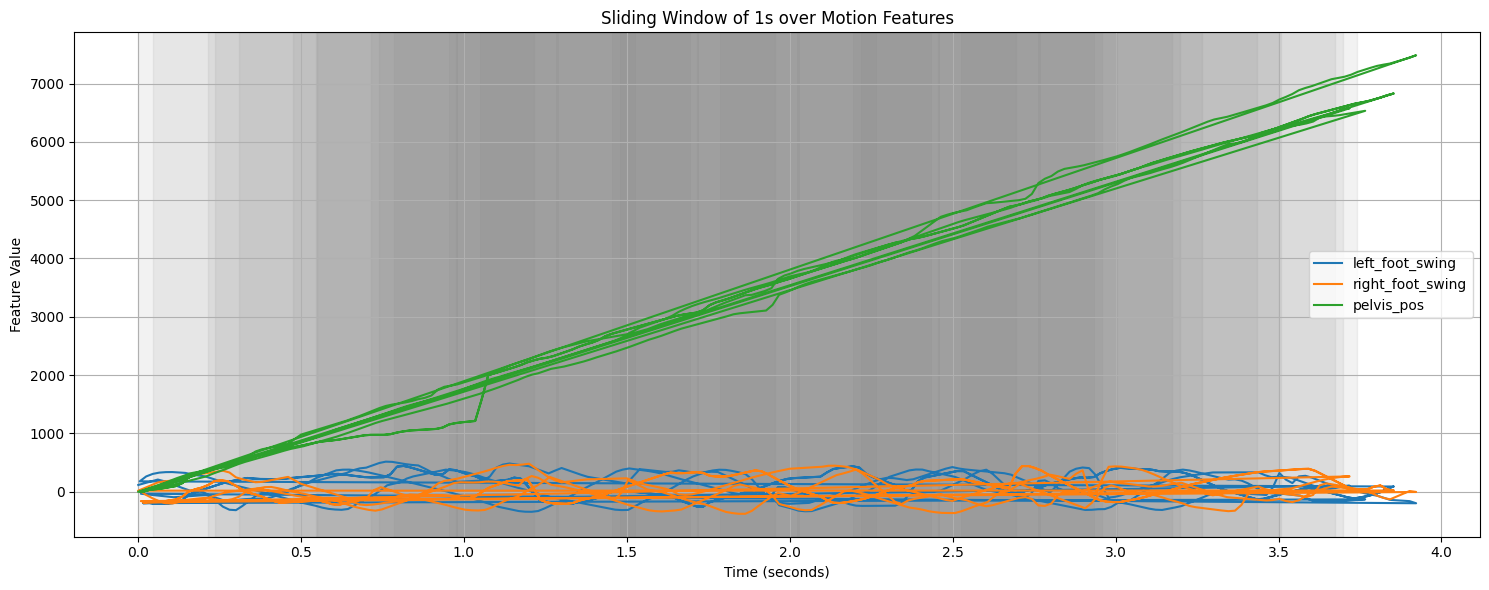

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv")

# Filter and pick sample trial
df = df[df['walking_speed'] == 'Fast']
sample_trial = df[df['patient_id'] == df['patient_id'].iloc[0]]
time = sample_trial['t_uniform'].values  # FIXED HERE

# Features to visualize
features_to_plot = ['left_foot_swing', 'right_foot_swing', 'pelvis_pos']

# Plot motion features
plt.figure(figsize=(15, 6))
for feature in features_to_plot:
    plt.plot(time, sample_trial[feature], label=feature)

# Add sliding window overlay
fps = 50
window_sec = 1
window_size = int(fps * window_sec)
stride = int(fps * 0.75)

for i in range(0, len(time) - window_size + 1, stride):
    plt.axvspan(time[i], time[i + window_size - 1], color='gray', alpha=0.1)

plt.title(f"Sliding Window of {window_sec}s over Motion Features")
plt.xlabel("Time (seconds)")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# ✅ Fully improved model with patient-wise splitting and no shuffling across patients

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# 📦 Load dataset
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# 📌 Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 🧱 Dataset
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        self.labels = []
        grouped = df.groupby(['patient_id', 'trial'])
        for _, group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for _, row in window.iterrows():
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label))
                self.labels.append(int(label.item()))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Patient-wise split
unique_ids = dataframe['patient_id'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)

train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
test_df  = dataframe[dataframe['patient_id'].isin(test_ids)]



wind_size = 30
stride_size = 1
b_size = 16



train_dataset = WindowedSkeletonDataset(train_df,window_size=wind_size, stride=stride_size)
test_dataset  = WindowedSkeletonDataset(test_df,window_size=wind_size, stride=stride_size)

# 📦 Dataloaders (no shuffle)
train_loader = DataLoader(train_dataset, batch_size=b_size)
test_loader  = DataLoader(test_dataset, batch_size=b_size)

# 🧠 Model
class WindowedSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

# ✅ Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WindowedSTGCN(in_channels=4, hidden_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(1, 100):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y in train_loader:
        x_seq, aux_seq, y = x_seq.to(device), aux_seq.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += y.size(0)
    print(f"Epoch {epoch:03d} | Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")

# 🧪 Final Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_seq, aux_seq, y in test_loader:
        x_seq, aux_seq = x_seq.to(device), aux_seq.to(device)
        out = torch.sigmoid(model(x_seq, aux_seq))
        pred = (out >= 0.5).float()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().view(-1).numpy())


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Good (0)", "Not Good (1)"]))

Epoch 001 | Loss: 21.7588 | Accuracy: 0.6838
Epoch 002 | Loss: 19.9750 | Accuracy: 0.6770
Epoch 003 | Loss: 18.8472 | Accuracy: 0.6901
Epoch 004 | Loss: 19.1750 | Accuracy: 0.6884
Epoch 005 | Loss: 19.0013 | Accuracy: 0.6868
Epoch 006 | Loss: 18.6892 | Accuracy: 0.6848
Epoch 007 | Loss: 18.3813 | Accuracy: 0.6851
Epoch 008 | Loss: 17.7473 | Accuracy: 0.6872
Epoch 009 | Loss: 17.5696 | Accuracy: 0.6897
Epoch 010 | Loss: 17.4173 | Accuracy: 0.6896
Epoch 011 | Loss: 17.2103 | Accuracy: 0.6898
Epoch 012 | Loss: 17.2510 | Accuracy: 0.6884
Epoch 013 | Loss: 16.8615 | Accuracy: 0.6892
Epoch 014 | Loss: 16.0803 | Accuracy: 0.6954
Epoch 015 | Loss: 15.9731 | Accuracy: 0.6961
Epoch 016 | Loss: 16.3125 | Accuracy: 0.6919
Epoch 017 | Loss: 15.7689 | Accuracy: 0.6948
Epoch 018 | Loss: 15.3337 | Accuracy: 0.6976
Epoch 019 | Loss: 15.3307 | Accuracy: 0.6986
Epoch 020 | Loss: 15.0842 | Accuracy: 0.6983
Epoch 021 | Loss: 14.7498 | Accuracy: 0.7020
Epoch 022 | Loss: 14.8920 | Accuracy: 0.6939
Epoch 023 

In [12]:
from collections import defaultdict
import pandas as pd
import torch

model.eval()
patient_results = defaultdict(list)

# Align test_df index to help lookup patient IDs
test_df = test_df.reset_index(drop=True)

with torch.no_grad():
    for i in range(len(test_dataset)):
        x_seq, aux_seq, y = test_dataset[i]
        patient_id = test_df.iloc[i]['patient_id']
        x_seq, aux_seq = x_seq.unsqueeze(0).to(device), aux_seq.unsqueeze(0).to(device)
        output = model(x_seq, aux_seq)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)
        true_label = int(y.item())

        patient_results[patient_id].append({
            'pred': pred_label,
            'true': true_label,
            'prob': prob
        })

# Build summary per patient
summary = []
for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum(p == t for p, t in zip(preds, trues))
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(valid_percentage, 2),
        'invalid_percentage': round(invalid_percentage, 2),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Convert to DataFrame and view
report_df = pd.DataFrame(summary).sort_values(by='PatientID').reset_index(drop=True)
display(report_df)

# Save if needed
# report_df.to_csv("QoR_Per_Patient_Report.csv", index=False)


,PatientID,Predicted_QoR_class,Actual_QoR_class,valid_percentage,invalid_percentage,average_model_output
0,001-LO,1,1,56.62,43.38,0.561562
1,005-GP,0,1,15.70,84.30,0.013678
2,006-TR,0,0,54.17,45.83,0.370372
3,010-RA,0,0,87.31,12.69,0.121712
4,011-CB,0,1,36.73,63.27,0.113834
5,013-MS,0,0,55.21,44.79,0.307052
6,018-OS,0,0,57.52,42.48,0.057361
7,020-MM,0,1,30.59,69.41,0.315053
8,025-PS,0,1,20.00,80.00,0.157386
9,033-JF,0,0,100.00,0.00,0.010680


#_____________________________________________________________________________________________________________________________________________________________________________________

In [11]:
# ✅ Final Complex Model with Residual GAT, Bi-LSTM, Multi-scale Input, Attention, and Focal Loss + Positional & Joint Embeddings + Class-Balanced Sampling

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler

# 📦 Load dataset
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# 📌 Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [(a, b) for a, b in zip(joints[:-1], joints[1:])]
joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 🧱 Dataset
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        self.labels = []
        grouped = df.groupby(['patient_id', 'trial'])
        for _, group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq, pos_seq = [], [], []
                for t, (_, row) in enumerate(window.iterrows()):
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                    pos_seq.append(t)
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.tensor(pos_seq), torch.stack(aux_seq), label))
                self.labels.append(int(label.item()))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Patient-wise split
unique_ids = dataframe['patient_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_ids)
train_ids = unique_ids[:int(0.7 * len(unique_ids))]
val_ids = unique_ids[int(0.7 * len(unique_ids)):int(0.85 * len(unique_ids))]
test_ids = unique_ids[int(0.85 * len(unique_ids)):] 

train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
val_df   = dataframe[dataframe['patient_id'].isin(val_ids)]
test_df  = dataframe[dataframe['patient_id'].isin(test_ids)]

train_dataset = WindowedSkeletonDataset(train_df)
val_dataset   = WindowedSkeletonDataset(val_df)
test_dataset  = WindowedSkeletonDataset(test_df)

weights = [1.0 / Counter(train_dataset.labels)[lbl] for lbl in train_dataset.labels]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# 🧠 Model
class ComplexGATModel(nn.Module):
    def __init__(self, in_channels=3, hidden_channels=128, heads=4, T=30):
        super().__init__()
        self.joint_embed = nn.Embedding(len(joints), in_channels)
        self.time_embed = nn.Embedding(T, in_channels)
        self.gat1 = GATConv(in_channels*2, hidden_channels, heads=heads, concat=True)
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        self.res_gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=True)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, bidirectional=True, batch_first=True)
        self.temporal_attn = nn.Linear(hidden_channels * 2, 1)
        self.aux_fc = nn.Sequential(nn.Linear(3, hidden_channels), nn.BatchNorm1d(hidden_channels), nn.ReLU())
        self.classifier = nn.Linear(hidden_channels * 3, 1)

    def forward(self, x_seq, time_seq, aux_seq):
        B, T, N, F = x_seq.shape
        j_idx = torch.arange(N, device=x_seq.device).repeat(B*T, 1)
        t_idx = time_seq.view(B*T, 1).repeat(1, N).to(x_seq.device)

        x_seq = x_seq.view(B * T, N, F)
        joint_emb = self.joint_embed(j_idx)
        time_emb = self.time_embed(t_idx)
        x = torch.cat([x_seq, joint_emb + time_emb], dim=-1).view(B*T*N, -1)

        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = torch.nn.functional.elu(self.gat1(x, full_edge_index))
        x = self.bn1(x)
        x = torch.nn.functional.elu(self.res_gat2(x, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)

        lstm_out, _ = self.lstm(x)
        attn_weights = torch.softmax(self.temporal_attn(lstm_out), dim=1)
        x = (attn_weights * lstm_out).sum(dim=1)

        aux = self.aux_fc(aux_seq.mean(1))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, smoothing=0.05):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing

    def forward(self, inputs, targets):
        targets = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean()

model = ComplexGATModel().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
criterion = FocalLoss()

class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                model.load_state_dict(self.best_model)
                return True
        return False

stopper = EarlyStopping()

for epoch in range(1, 100):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, time_seq, aux_seq, y in train_loader:
        x_seq, time_seq, aux_seq, y = x_seq.cuda(), time_seq.cuda(), aux_seq.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x_seq, time_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += y.size(0)
    train_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x_seq, time_seq, aux_seq, y in val_loader:
            x_seq, time_seq, aux_seq, y = x_seq.cuda(), time_seq.cuda(), aux_seq.cuda(), y.cuda()
            out = model(x_seq, time_seq, aux_seq)
            loss = criterion(out, y)
            val_loss += loss.item() * y.size(0)
            val_correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
            val_total += y.size(0)
    val_acc = val_correct / val_total
    print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss / val_total:.4f} | Val Acc: {val_acc:.4f}")
    if stopper.step(val_loss / val_total, model):
        print("Early stopping triggered.")
        break

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_seq, time_seq, aux_seq, y in test_loader:
        x_seq, time_seq, aux_seq = x_seq.cuda(), time_seq.cuda(), aux_seq.cuda()
        out = torch.sigmoid(model(x_seq, time_seq, aux_seq))
        pred = (out >= 0.5).float()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().view(-1).numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Good (0)", "Not Good (1)"]))

Epoch 001 | Train Acc: 0.5550 | Val Loss: 0.1873 | Val Acc: 0.4279
Epoch 002 | Train Acc: 0.6043 | Val Loss: 0.1914 | Val Acc: 0.4254
Epoch 003 | Train Acc: 0.5973 | Val Loss: 0.2024 | Val Acc: 0.5149
Epoch 004 | Train Acc: 0.6157 | Val Loss: 0.2036 | Val Acc: 0.5050
Epoch 005 | Train Acc: 0.6106 | Val Loss: 0.2241 | Val Acc: 0.5398
Epoch 006 | Train Acc: 0.5872 | Val Loss: 0.2236 | Val Acc: 0.4876
Epoch 007 | Train Acc: 0.6441 | Val Loss: 0.2515 | Val Acc: 0.5597
Epoch 008 | Train Acc: 0.6460 | Val Loss: 0.2512 | Val Acc: 0.5124
Epoch 009 | Train Acc: 0.6258 | Val Loss: 0.2652 | Val Acc: 0.5323
Epoch 010 | Train Acc: 0.6422 | Val Loss: 0.2596 | Val Acc: 0.5572
Epoch 011 | Train Acc: 0.6264 | Val Loss: 0.2964 | Val Acc: 0.5149
Early stopping triggered.

Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.49      0.56      0.52       212
Not Good (1)       0.71      0.65      0.68       352

    accuracy                           0.62      

In [15]:
# ✅ Final Complex Model with Multi-scale Temporal Input + Residual GAT + Attention

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

# 📦 Load dataset
path = "C:/Users/RAZER/Desktop/TEMp/New folder/KINECT_dataset_with_qor15.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.dropna(subset=['QoR_class'], inplace=True)

# 📌 Graph structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [(a, b) for a, b in zip(joints[:-1], joints[1:])]
joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] + 
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 🧱 Dataset
class WindowedSkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=30, stride=15):
        self.samples = []
        self.labels = []
        grouped = df.groupby(['patient_id', 'trial'])
        for _, group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq, aux_seq = [], []
                for j in range(len(window)):
                    row = window.iloc[j]
                    node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    x_seq.append(torch.tensor(node_features, dtype=torch.float))
                    aux_seq.append(torch.tensor([row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']], dtype=torch.float))
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((torch.stack(x_seq), torch.stack(aux_seq), label))
                self.labels.append(int(label.item()))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Patient-wise split
unique_ids = dataframe['patient_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_ids)
train_ids = unique_ids[:int(0.7 * len(unique_ids))]
val_ids = unique_ids[int(0.7 * len(unique_ids)):int(0.85 * len(unique_ids))]
test_ids = unique_ids[int(0.85 * len(unique_ids)):] 

train_df = dataframe[dataframe['patient_id'].isin(train_ids)]
val_df   = dataframe[dataframe['patient_id'].isin(val_ids)]
test_df  = dataframe[dataframe['patient_id'].isin(test_ids)]

train_dataset = WindowedSkeletonDataset(train_df)
val_dataset   = WindowedSkeletonDataset(val_df)
test_dataset  = WindowedSkeletonDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# 🧠 Multi-scale GAT-LSTM-Attention Model
class MultiScaleGATLSTM(nn.Module):
    def __init__(self, in_channels=4, hidden_channels=128):
        super().__init__()
        self.gat = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.bn1 = nn.BatchNorm1d(hidden_channels * 4)
        self.res_gat = GATConv(hidden_channels * 4, hidden_channels, heads=1)
        self.lstm_short = nn.LSTM(hidden_channels, hidden_channels, batch_first=True, bidirectional=True)
        self.lstm_long  = nn.LSTM(hidden_channels, hidden_channels, batch_first=True, bidirectional=True)
        self.temporal_attn = nn.Linear(hidden_channels * 4, 1)
        self.aux_fc = nn.Sequential(nn.Linear(3, hidden_channels), nn.BatchNorm1d(hidden_channels), nn.ReLU())
        self.classifier = nn.Linear(hidden_channels * 5, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        edge_idx = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.elu(self.gat(x_seq, edge_idx))
        x = self.bn1(x)
        x = F.elu(self.res_gat(x, edge_idx))
        x = x.view(B, T, N, -1).mean(2)
        lstm_out_short, _ = self.lstm_short(x)
        lstm_out_long, _  = self.lstm_long(x.flip(1))
        x = torch.cat([lstm_out_short, lstm_out_long.flip(1)], dim=-1)
        attn_weights = torch.softmax(self.temporal_attn(x), dim=1)
        x = (attn_weights * x).sum(1)
        aux = self.aux_fc(aux_seq.mean(1))
        return self.classifier(torch.cat([x, aux], dim=-1)).squeeze()

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce)
        return (self.alpha * (1 - pt) ** self.gamma * bce).mean()

model = MultiScaleGATLSTM().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = FocalLoss()

class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None

    def step(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                model.load_state_dict(self.best_model)
                return True
        return False

stopper = EarlyStopping()

for epoch in range(1, 100):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y in train_loader:
        x_seq, aux_seq, y = x_seq.cuda(), aux_seq.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += y.size(0)
    train_acc = correct / total

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for x_seq, aux_seq, y in val_loader:
            x_seq, aux_seq, y = x_seq.cuda(), aux_seq.cuda(), y.cuda()
            out = model(x_seq, aux_seq)
            loss = criterion(out, y)
            val_loss += loss.item() * y.size(0)
            val_correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
            val_total += y.size(0)
    val_acc = val_correct / val_total
    print(f"Epoch {epoch:03d} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss / val_total:.4f} | Val Acc: {val_acc:.4f}")
    if stopper.step(val_loss / val_total, model):
        print("Early stopping triggered.")
        break

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x_seq, aux_seq, y in test_loader:
        x_seq, aux_seq = x_seq.cuda(), aux_seq.cuda()
        out = torch.sigmoid(model(x_seq, aux_seq))
        pred = (out >= 0.5).float()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().view(-1).numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Good (0)", "Not Good (1)"]))


Epoch 001 | Train Acc: 0.5006 | Val Loss: 0.1903 | Val Acc: 0.4726
Epoch 002 | Train Acc: 0.5676 | Val Loss: 0.1965 | Val Acc: 0.4801
Epoch 003 | Train Acc: 0.6637 | Val Loss: 0.1983 | Val Acc: 0.4801
Epoch 004 | Train Acc: 0.6675 | Val Loss: 0.1982 | Val Acc: 0.4801
Epoch 005 | Train Acc: 0.6675 | Val Loss: 0.1988 | Val Acc: 0.4801
Epoch 006 | Train Acc: 0.6675 | Val Loss: 0.2009 | Val Acc: 0.4801
Epoch 007 | Train Acc: 0.6675 | Val Loss: 0.2011 | Val Acc: 0.4801
Epoch 008 | Train Acc: 0.6688 | Val Loss: 0.2016 | Val Acc: 0.4801
Epoch 009 | Train Acc: 0.6694 | Val Loss: 0.2023 | Val Acc: 0.4801
Epoch 010 | Train Acc: 0.6707 | Val Loss: 0.2043 | Val Acc: 0.4801
Epoch 011 | Train Acc: 0.6707 | Val Loss: 0.2048 | Val Acc: 0.4801
Early stopping triggered.

Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.38      1.00      0.55       212
Not Good (1)       0.00      0.00      0.00       352

    accuracy                           0.38      

c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

#___________________________________________________________________________________________________________________________________

In [84]:
path = "/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/Kinect-ACC-data_S01-S104_panda_2025-04-17_23-33PM.csv"
dataframe = pd.read_csv(path)
dataframe

,patient_id,trial,walking_speed,t_uniform,ACC_1,ACC_2,ACC_3,ACC_4,ACC_5,ACC_6,...,FOOT_RIGHT_Z,HEAD_Z,NOSE_Z,EYE_LEFT_Z,EAR_LEFT_Z,EYE_RIGHT_Z,EAR_RIGHT_Z,left_foot_swing,pelvis_pos,right_foot_swing
0,001-LO,Trial4,Fast,0.001646,1.060914e-07,2.811981e-08,2.464734e-08,1.511133e-07,6.088732e-08,2.521242e-08,...,7180.869629,-100.915652,-1062.272713,7108.170184,-114.104415,-1046.162440,7230.420053,115.919472,0.000000,17.725769
1,001-LO,Trial4,Fast,0.021627,5.940475e-08,8.744008e-08,3.596533e-08,1.409464e-07,1.330034e-07,8.532096e-08,...,7151.173528,-98.805775,-1067.001900,7077.772048,-109.613466,-1035.117093,7194.746026,146.795342,36.722235,64.687058
2,001-LO,Trial4,Fast,0.041607,4.536440e-08,8.054273e-08,6.073777e-08,5.997389e-08,9.580592e-08,2.747907e-08,...,7121.477428,-96.695898,-1071.731086,7047.373913,-105.122517,-1024.071745,7159.071999,177.671212,73.444469,111.648347
3,001-LO,Trial4,Fast,0.061588,3.443630e-08,9.337871e-09,5.133352e-08,1.558557e-07,5.318491e-08,1.614723e-07,...,7091.781328,-94.586020,-1076.460273,7016.975777,-100.631568,-1013.026398,7123.397972,208.547082,110.166704,158.609636
4,001-LO,Trial4,Fast,0.081568,5.839159e-08,6.049488e-08,4.505175e-08,1.287962e-07,1.261326e-07,2.601005e-08,...,7071.324594,-80.853692,-1079.380860,6990.668229,-97.752732,-1044.910963,7105.608067,179.849426,150.343338,177.675136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117155,Cln-104,AB,Trial2,4.830416,8.546434e-08,1.231404e-07,6.787851e-08,1.330603e-07,7.839641e-08,2.384085e-07,...,1048.442017,-126.750295,-551.180569,970.203929,-152.365755,-571.839879,1079.255278,59.970601,6319.892406,211.344469
117156,Cln-104,AB,Trial2,4.850396,1.242602e-07,1.269886e-07,5.852673e-08,1.682999e-07,2.775768e-07,2.565965e-08,...,1033.144328,-127.544725,-554.904292,959.564131,-148.180238,-571.823610,1070.899947,59.247578,6337.863535,222.721413
117157,Cln-104,AB,Trial2,4.870377,6.017464e-08,8.823748e-08,2.797314e-08,2.230998e-07,2.216193e-07,2.486080e-08,...,1017.931637,-127.695136,-559.719659,947.845337,-144.654785,-571.793346,1061.019768,60.637927,6355.245492,226.640885
117158,Cln-104,AB,Trial2,4.890357,2.572769e-07,1.509836e-07,1.535920e-07,1.680945e-07,4.465755e-08,4.777928e-08,...,1003.254027,-127.013617,-565.256771,935.386698,-141.856427,-572.017329,1049.609657,65.719827,6371.699373,212.221827


#### Patient Grouped Model_1

In [19]:
import pandas as pd

# Load both datasets
df1 = pd.read_csv(r"C:\Users\RAZER\Desktop\New folder\Kinect-ACC-data_S01-S104_panda_2025-04-18_13-16PM.csv")   # Replace with actual path
df2 = pd.read_csv(r"C:\Users\RAZER\Desktop\New folder\AIFrailtyCaseReportF_DATA_2025-04-15_1354.csv")  # Replace with actual path

# Strip any whitespace in column names
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

# Rename 'record_id' to 'patient_id' in df2
df2.rename(columns={'record_id': 'patient_id'}, inplace=True)

# Convert to string to ensure consistent merge
df1['patient_id'] = df1['patient_id'].astype(str)
df2['patient_id'] = df2['patient_id'].astype(str)

# Extract qor15_score per patient
qor_df = df2[['patient_id', 'qor15_score']].drop_duplicates()

# Merge the score into df1
df1_with_qor = pd.merge(df1, qor_df, on='patient_id', how='left')

# Optional: Save or display results
print(df1_with_qor[['patient_id', 'qor15_score']].head())
# df1_with_qor.to_csv("merged_with_qor.csv", index=False)


  patient_id  qor15_score
0     001-LO         92.0
1     001-LO         92.0
2     001-LO         92.0
3     001-LO         92.0
4     001-LO         92.0


In [ ]:
# Ensure correct column name and strip whitespace
df2.columns = df2.columns.str.strip()

# Check for missing qor15_score
missing_qor = df2[df2['qor15_score'].isna()]

# Show unique patients with missing scores
missing_patients = missing_qor['patient_id'].unique()

print(f"Number of patients with missing QoR15 scores: {len(missing_patients)}")
print("Patient IDs with missing QoR15 scores:")
print(missing_patients)


Number of patients with missing QoR15 scores: 15
Patient IDs with missing QoR15 scores:
['078-SM' '084-SL' '085-AH' '093-NO' '094-JB' '095-MT' '096-RF' '097-MH'
 '098-CM' '099-RC' '104-AB' '105-CC' '106-NR' '107-LZ' '108-SC']


In [21]:
df1_with_qor

,patient_id,trial,walking_speed,t_uniform,ACC_1,ACC_2,ACC_3,ACC_4,ACC_5,ACC_6,...,HEAD_Z,NOSE_Z,EYE_LEFT_Z,EAR_LEFT_Z,EYE_RIGHT_Z,EAR_RIGHT_Z,left_foot_swing,pelvis_pos,right_foot_swing,qor15_score
0,001-LO,Trial4,Fast,0.001646,1.060914e-07,2.811981e-08,2.464734e-08,1.511133e-07,6.088732e-08,2.521242e-08,...,-100.915652,-1062.272713,7108.170184,-114.104415,-1046.162440,7230.420053,115.919472,0.000000,17.725769,92.0
1,001-LO,Trial4,Fast,0.021627,5.940475e-08,8.744008e-08,3.596533e-08,1.409464e-07,1.330034e-07,8.532096e-08,...,-98.805775,-1067.001900,7077.772048,-109.613466,-1035.117093,7194.746026,146.795342,36.722235,64.687058,92.0
2,001-LO,Trial4,Fast,0.041607,4.536440e-08,8.054273e-08,6.073777e-08,5.997389e-08,9.580592e-08,2.747907e-08,...,-96.695898,-1071.731086,7047.373913,-105.122517,-1024.071745,7159.071999,177.671212,73.444469,111.648347,92.0
3,001-LO,Trial4,Fast,0.061588,3.443630e-08,9.337871e-09,5.133352e-08,1.558557e-07,5.318491e-08,1.614723e-07,...,-94.586020,-1076.460273,7016.975777,-100.631568,-1013.026398,7123.397972,208.547082,110.166704,158.609636,92.0
4,001-LO,Trial4,Fast,0.081568,5.839159e-08,6.049488e-08,4.505175e-08,1.287962e-07,1.261326e-07,2.601005e-08,...,-80.853692,-1079.380860,6990.668229,-97.752732,-1044.910963,7105.608067,179.849426,150.343338,177.675136,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117155,104-AB,Trial2,Regular,4.830416,8.546434e-08,1.231404e-07,6.787851e-08,1.330603e-07,7.839641e-08,2.384085e-07,...,-126.750295,-551.180569,970.203929,-152.365755,-571.839879,1079.255278,59.970601,6319.892406,211.344469,NaN
117156,104-AB,Trial2,Regular,4.850396,1.242602e-07,1.269886e-07,5.852673e-08,1.682999e-07,2.775768e-07,2.565965e-08,...,-127.544725,-554.904292,959.564131,-148.180238,-571.823610,1070.899947,59.247578,6337.863535,222.721413,NaN
117157,104-AB,Trial2,Regular,4.870377,6.017464e-08,8.823748e-08,2.797314e-08,2.230998e-07,2.216193e-07,2.486080e-08,...,-127.695136,-559.719659,947.845337,-144.654785,-571.793346,1061.019768,60.637927,6355.245492,226.640885,NaN
117158,104-AB,Trial2,Regular,4.890357,2.572769e-07,1.509836e-07,1.535920e-07,1.680945e-07,4.465755e-08,4.777928e-08,...,-127.013617,-565.256771,935.386698,-141.856427,-572.017329,1049.609657,65.719827,6371.699373,212.221827,NaN


In [22]:
# Remove rows where qor15_score is NaN
df1_cleaned = df1_with_qor.dropna(subset=['qor15_score'])

# Check result
print(f"Original rows: {len(df1_with_qor)}")
print(f"Rows after dropping NaN qor15_score: {len(df1_cleaned)}")


Original rows: 117160
Rows after dropping NaN qor15_score: 98281


In [24]:
conditions = [
    (df1_cleaned['qor15_score'] >= 0) & (df1_cleaned['qor15_score'] <= 110),
    (df1_cleaned['qor15_score'] >= 111) & (df1_cleaned['qor15_score'] <= 150)
]

values = [1,0]  # 1 = 'Not Good', 0 = 'Good'

df1_cleaned['QoR_class'] = np.select(conditions, values,default=np.nan)

C:\Users\RAZER\AppData\Local\Temp\ipykernel_19172\1001671939.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_cleaned['QoR_class'] = np.select(conditions, values,default=np.nan)


In [25]:
output_filename = "KINECT_dataset_with_qor15.csv"
df1_cleaned.to_csv(output_filename, index=False)
print(f"✅ Saved: {output_filename}")


✅ Saved: KINECT_dataset_with_qor15.csv


In [26]:
df1_cleaned

,patient_id,trial,walking_speed,t_uniform,ACC_1,ACC_2,ACC_3,ACC_4,ACC_5,ACC_6,...,NOSE_Z,EYE_LEFT_Z,EAR_LEFT_Z,EYE_RIGHT_Z,EAR_RIGHT_Z,left_foot_swing,pelvis_pos,right_foot_swing,qor15_score,QoR_class
0,001-LO,Trial4,Fast,0.001646,1.060914e-07,2.811981e-08,2.464734e-08,1.511133e-07,6.088732e-08,2.521242e-08,...,-1062.272713,7108.170184,-114.104415,-1046.162440,7230.420053,115.919472,0.000000,17.725769,92.0,1.0
1,001-LO,Trial4,Fast,0.021627,5.940475e-08,8.744008e-08,3.596533e-08,1.409464e-07,1.330034e-07,8.532096e-08,...,-1067.001900,7077.772048,-109.613466,-1035.117093,7194.746026,146.795342,36.722235,64.687058,92.0,1.0
2,001-LO,Trial4,Fast,0.041607,4.536440e-08,8.054273e-08,6.073777e-08,5.997389e-08,9.580592e-08,2.747907e-08,...,-1071.731086,7047.373913,-105.122517,-1024.071745,7159.071999,177.671212,73.444469,111.648347,92.0,1.0
3,001-LO,Trial4,Fast,0.061588,3.443630e-08,9.337871e-09,5.133352e-08,1.558557e-07,5.318491e-08,1.614723e-07,...,-1076.460273,7016.975777,-100.631568,-1013.026398,7123.397972,208.547082,110.166704,158.609636,92.0,1.0
4,001-LO,Trial4,Fast,0.081568,5.839159e-08,6.049488e-08,4.505175e-08,1.287962e-07,1.261326e-07,2.601005e-08,...,-1079.380860,6990.668229,-97.752732,-1044.910963,7105.608067,179.849426,150.343338,177.675136,92.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116222,103-EL,Trial1,Regular,6.707664,5.972912e-08,1.134457e-07,5.261496e-08,2.336223e-07,5.110197e-07,1.117463e-07,...,-3089.035857,9028.674592,-430.266787,-2997.242862,8959.420383,-24.779956,9080.362502,78.283203,147.0,0.0
116223,103-EL,Trial1,Regular,6.727645,3.661211e-08,7.727416e-08,1.314309e-07,9.129969e-08,1.937610e-07,1.328458e-07,...,-3090.762742,9071.192894,-420.138467,-3012.950130,8989.417378,2.911325,9111.940400,91.246996,147.0,0.0
116224,103-EL,Trial1,Regular,6.747625,8.371982e-08,1.195418e-07,1.952548e-07,1.874322e-07,1.476048e-07,3.796125e-07,...,-3092.489627,9113.711195,-410.010146,-3028.657398,9019.414373,30.602606,9143.518299,104.210789,147.0,0.0
116225,103-EL,Trial1,Regular,6.767606,1.335281e-07,9.995913e-08,1.378724e-07,1.501196e-08,1.890996e-07,9.520563e-08,...,-3094.216512,9156.229497,-399.881826,-3044.364666,9049.411369,58.293887,9175.096198,117.174582,147.0,0.0


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

# 1. Load Data
path = r"C:\Users\RAZER\Desktop\TEMp\New folder\KINECT_dataset_with_qor15.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.rename(columns={'patient_id':'patientID'}, inplace=True)
dataframe.rename(columns={'t_uniform':'timeStamps'}, inplace=True)


In [4]:
print(dataframe)

      patientID   trial walking_speed  timeStamps         ACC_1         ACC_2  \
0        001-LO  Trial4          Fast    0.001646  1.060914e-07  2.811981e-08   
1        001-LO  Trial4          Fast    0.021627  5.940475e-08  8.744008e-08   
2        001-LO  Trial4          Fast    0.041607  4.536440e-08  8.054273e-08   
3        001-LO  Trial4          Fast    0.061588  3.443630e-08  9.337871e-09   
4        001-LO  Trial4          Fast    0.081568  5.839159e-08  6.049488e-08   
...         ...     ...           ...         ...           ...           ...   
97648    103-EL  Trial3          Fast    4.307818  5.358699e-08  9.066990e-08   
97649    103-EL  Trial3          Fast    4.327799  9.235556e-08  1.116539e-07   
97650    103-EL  Trial3          Fast    4.347779  1.015234e-07  5.848282e-08   
97651    103-EL  Trial3          Fast    4.367759  1.249084e-06  6.477975e-06   
97652    103-EL  Trial3          Fast    4.387740  1.449812e-05  1.068348e-06   

              ACC_3        

In [2]:
dataframe

,patientID,trial_num,walking_speed,timeStamps,PELVIS_X,SPINE_NAVAL_X,SPINE_CHEST_X,NECK_X,CLAVICLE_LEFT_X,SHOULDER_LEFT_X,...,comp4_type,comp4_cd,comp4_desc,comp5_type,comp5_cd,comp5_desc,cc_index,notes,postoperative_3day_data_complete,QoR_class
0,001-LO,Trial4,Fast,0.001646,-36.173563,-32.222103,-29.139376,-24.572845,6.011915,125.887829,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,1.0
1,001-LO,Trial4,Fast,0.021627,-26.631417,-24.712284,-23.071704,-19.095052,11.770258,132.878366,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,1.0
2,001-LO,Trial4,Fast,0.041607,-17.089270,-17.202465,-17.004033,-13.617259,17.528602,139.868903,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,1.0
3,001-LO,Trial4,Fast,0.061588,-7.547124,-9.692646,-10.936362,-8.139466,23.286945,146.859440,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,1.0
4,001-LO,Trial4,Fast,0.081568,-13.797027,-19.793992,-23.898339,-14.030918,16.551726,142.158210,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116132,104-AB,Trial3,Fast,5.476507,-297.419587,-289.903213,-284.087081,-274.576418,-308.355566,-437.509034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
116133,104-AB,Trial3,Fast,5.496488,-299.466979,-291.817485,-286.041926,-277.012028,-311.263065,-441.682267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
116134,104-AB,Trial3,Fast,5.516468,-302.713189,-294.452695,-287.902636,-271.912967,-306.166817,-432.081051,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
116135,104-AB,Trial3,Fast,5.536449,-305.959399,-297.087905,-289.763346,-266.813906,-301.070569,-422.479836,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle

# 1. Load Data
path =  r"D:\Data\NYC\KINZ\KINECT_ACC_dataset_with_qor15_2025-05-27_14-29PM.csv"
dataframe = pd.read_csv(path)
dataframe = dataframe[dataframe['walking_speed'] == 'Fast']
dataframe.rename(columns={'patient_id':'patientID'}, inplace=True)
dataframe.rename(columns={'t_uniform':'timeStamps'}, inplace=True)

# 2. Graph Definition
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD','EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
                          [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],
                          dtype=torch.long).t()

# 3. Dataset
class SkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df
        self.num_nodes = len(joints)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        node_features = [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
        x = torch.tensor(node_features, dtype=torch.float)
        y = torch.tensor(row['QoR_class'], dtype=torch.float)
        return Data(x=x, edge_index=edge_index, y=y)

# 4. Random split
full_dataset = SkeletonDataset(dataframe.dropna(subset=['QoR_class']))
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# 5. Weighted Sampling
train_indices = train_dataset.indices if isinstance(train_dataset, torch.utils.data.Subset) else list(range(len(train_dataset)))
train_df = dataframe.iloc[train_indices].reset_index(drop=True)
train_df = train_df.dropna(subset=['QoR_class'])
class_counts = train_df['QoR_class'].value_counts().sort_index().to_numpy()
class_weights = 1. / class_counts
sample_weights = [class_weights[int(label)] for label in train_df['QoR_class']]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# 6. Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 7. Model
class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.temporal_conv1 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        batch_size = batch.max().item() + 1 if batch is not None else 1
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1).permute(0, 2, 1)
        x = F.relu(self.temporal_conv1(x)).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze()

# 8. Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
pos_weight = torch.tensor([class_weights[0] / class_weights[1]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.005):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                if self.best_model is not None:
                    model.load_state_dict(self.best_model)
                return True
        return False

# 9. Training Loop
num_epochs = 100
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
early_stopping = EarlyStopping()

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        y = data.y.to(device).float()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        correct += ((out >= 0.5) == y).sum().item()
        total += data.num_graphs
    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / total

    model.eval()
    total_loss, correct, total, all_preds, all_labels = 0, 0, 0, [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            y = data.y.to(device).float()
            loss = criterion(out, y)
            total_loss += loss.item() * data.num_graphs
            pred = (torch.sigmoid(out) >= 0.5).float()
            correct += (pred == y).sum().item()
            total += data.num_graphs
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = correct / total
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    if early_stopping(test_loss, model):
        print("Early stopping triggered.")
        break

# 10. Final Evaluation
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
roc_auc = roc_auc_score(all_labels, all_preds)
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
specificity = tn / (tn + fp)

print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=['Good (0)', 'Not Good (1)']))

# 11. Save Model + Stats
now = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f"QOR_hybrid_stgcn_model_{now}.pth")
with open(f"QOR_hybrid_stgcn_model_statistics_{now}.pkl", 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_metrics': {
            'accuracy': accuracy,
            'f1_score': f1,
            'recall': recall,
            'precision': precision,
            'specificity': specificity,
            'roc_auc': roc_auc
        }
    }, f)
print("Model and statistics saved.")


C:\Users\user\AppData\Local\Temp\ipykernel_22056\3818953304.py:18: DtypeWarning: Columns (108,112,113,117,151,154,161,162,164,169,180,185,198,221,228,264,267,269,270,306,307,310,311,314,315,318,319,322,323,326,328,330,331,334,335,338,339,342,343,346,348,350,352,354,356,358,362,363,393,403,404,406,418,423,430,433,436,439,444) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv(path)


KeyError: 't_uniform'

In [ ]:
from collections import defaultdict
import torch
import torch.nn.functional as F
import pandas as pd
from IPython.display import display


#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = HybridSTGCN(in_channels=4, hidden_channels=128, num_classes=1).to(device)
#saved_model_path = "QOR_hybrid_stgcn_model_20250505_XXXXXX.pth"
#model.load_state_dict(torch.load(saved_model_path, map_location=device))



model.eval()

# To store all test predictions, true labels, and outputs
patient_results = defaultdict(list)

with torch.no_grad():
    for i in range(len(test_dataset)):
        data = test_dataset[i]
        patient_id = dataframe.iloc[test_dataset.indices[i]]['patientID']
        true_label = data.y.item()

        data = data.to(device)
        output = model(data)
        prob = torch.sigmoid(output).item()
        pred_label = int(prob >= 0.5)

        patient_results[patient_id].append({
            'pred': pred_label,
            'true': int(true_label),
            'prob': prob
        })

# Summarize per-patient
summary = []

for pid, records in patient_results.items():
    preds = [r['pred'] for r in records]
    trues = [r['true'] for r in records]
    probs = [r['prob'] for r in records]

    correct_count = sum([p == t for p, t in zip(preds, trues)])
    total = len(records)
    valid_percentage = 100 * correct_count / total
    invalid_percentage = 100 - valid_percentage

    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),  # majority
        'Actual_QoR_class': max(set(trues), key=trues.count),    # majority
        'valid_percentage': round(valid_percentage, 6),
        'invalid_percentage': round(invalid_percentage, 6),
        'average_model_output': round(sum(probs) / len(probs), 6)
    })

# Convert to DataFrame
report_df = pd.DataFrame(summary)

# Optional: sort by PatientID or any metric
report_df.sort_values(by='PatientID', inplace=True)

# Display or save
from IPython.display import display
display(report_df)

# Save to CSV
#report_df.to_csv("QoR_Per_Patient_Report.csv", index=False)
print("✅ Report saved as 'QoR_Per_Patient_Report.csv'")


,PatientID,Predicted_QoR_class,Actual_QoR_class,valid_percentage,invalid_percentage,average_model_output
22,001-LO,1,1,100.000000,0.000000,0.998556
44,002-RJ,1,1,91.860465,8.139535,0.847779
14,003-RM,0,0,82.352941,17.647059,0.203926
51,004-MF,0,0,91.447368,8.552632,0.171494
72,005-GP,0,0,81.395349,18.604651,0.276777
...,...,...,...,...,...,...
1,089-JH,1,1,95.477387,4.522613,0.575103
42,092-CG,0,0,90.340909,9.659091,0.437298
0,100-JG,0,0,100.000000,0.000000,0.424405
19,101-WZ,0,0,94.488189,5.511811,0.077021


✅ Report saved as 'QoR_Per_Patient_Report.csv'


# Cross Validation 

In [40]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
import pandas as pd
from collections import defaultdict
from datetime import datetime

# 1. Load data
path = r"C:\Users\RAZER\Desktop\New folder\KINECT_dataset_with_qor15.csv"
df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.rename(columns={'patient_id': 'patientID', 't_uniform': 'timeStamps'}, inplace=True)
df = df.dropna(subset=['QoR_class'])

# 2. Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
    ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],
    dtype=torch.long
).t()

# 3. Define dataset
class SkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        x = torch.tensor([
            [row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['timeStamps']] for j in joints
        ], dtype=torch.float)
        y = torch.tensor(row['QoR_class'], dtype=torch.float)
        return Data(x=x, edge_index=edge_index, y=y), row['patientID']

# 4. Define model
class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.temporal_conv1 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        batch_size = batch.max().item() + 1 if batch is not None else 1
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1).permute(0, 2, 1)
        x = F.relu(self.temporal_conv1(x)).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x.squeeze()

# 5. GroupKFold Cross-validation
kf = GroupKFold(n_splits=5)
dataset = SkeletonDataset(df)

# Collect all samples
all_data = [dataset[i] for i in range(len(dataset))]
data_list, group_list = zip(*all_data)

fold = 1
for train_idx, test_idx in kf.split(data_list, [d.y.item() for d in data_list], group_list):
    print(f"===== Fold {fold} =====")

    train_data = [data_list[i] for i in train_idx]
    test_data = [data_list[i] for i in test_idx]

    train_labels = [d.y.item() for d in train_data]
    class_counts = np.bincount(np.array(train_labels, dtype=int))
    class_weights = 1. / class_counts
    sample_weights = [class_weights[int(label)] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    train_loader = DataLoader(train_data, batch_size=8, sampler=sampler)
    test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

    model = HybridSTGCN(4, 128, 1).to('cuda')
    pos_weight = torch.tensor([class_weights[0] / class_weights[1]]).to('cuda')
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

    for epoch in range(1, 21):
        model.train()
        total_loss = 0
        for batch in train_loader:
            data = batch.to('cuda')
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y.to('cuda'))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        print(f"Epoch {epoch:03d}, Loss: {total_loss/len(train_loader.dataset):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            data = batch.to('cuda')
            out = torch.sigmoid(model(data))
            pred = (out >= 0.5).float()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp)

    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, AUC: {roc_auc:.4f}\n")

    fold += 1

===== Fold 1 =====
Epoch 001, Loss: 0.5457
Epoch 002, Loss: 0.5168
Epoch 003, Loss: 0.4718
Epoch 004, Loss: 0.4284
Epoch 005, Loss: 0.3880
Epoch 006, Loss: 0.3521
Epoch 007, Loss: 0.3238
Epoch 008, Loss: 0.3016
Epoch 009, Loss: 0.2835
Epoch 010, Loss: 0.2660
Epoch 011, Loss: 0.2497
Epoch 012, Loss: 0.2350
Epoch 013, Loss: 0.2218
Epoch 014, Loss: 0.2089
Epoch 015, Loss: 0.2001
Epoch 016, Loss: 0.1854
Epoch 017, Loss: 0.1822
Epoch 018, Loss: 0.1760
Epoch 019, Loss: 0.1677
Epoch 020, Loss: 0.1572
Accuracy: 0.4394, F1: 0.2647, Recall: 0.1859, Precision: 0.4593, Specificity: 0.7403, AUC: 0.4631

===== Fold 2 =====
Epoch 001, Loss: 0.4833
Epoch 002, Loss: 0.4463
Epoch 003, Loss: 0.4132
Epoch 004, Loss: 0.3809
Epoch 005, Loss: 0.3458
Epoch 006, Loss: 0.3157
Epoch 007, Loss: 0.2818
Epoch 008, Loss: 0.2582
Epoch 009, Loss: 0.2331
Epoch 010, Loss: 0.2161
Epoch 011, Loss: 0.2006
Epoch 012, Loss: 0.1827


KeyboardInterrupt: 

In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix
import pandas as pd
from collections import defaultdict
from datetime import datetime

# 1. Load data
path = r"C:\Users\RAZER\Desktop\New folder\KINECT_dataset_with_qor15.csv"
df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.rename(columns={'patient_id': 'patientID', 't_uniform': 'timeStamps'}, inplace=True)
df = df.dropna(subset=['QoR_class'])

# 2. Define joints and edges
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT', 'ELBOW_LEFT', 'WRIST_LEFT',
          'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT', 'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT',
          'HAND_RIGHT', 'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT', 'FOOT_LEFT', 'HIP_RIGHT',
          'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT', 'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'), ('NECK', 'HEAD'),
         ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'), ('SHOULDER_LEFT', 'ELBOW_LEFT'),
         ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'), ('HAND_LEFT', 'HANDTIP_LEFT'),
         ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'), ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'),
         ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'), ('WRIST_RIGHT', 'HAND_RIGHT'),
         ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'), ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'),
         ('KNEE_LEFT', 'ANKLE_LEFT'), ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'), ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'),
         ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}

edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],
    dtype=torch.long
).t()

# 3. Define dataset
class SkeletonDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data = df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        x = torch.tensor([
            [row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['timeStamps']] for j in joints
        ], dtype=torch.float)
        y = torch.tensor(row['QoR_class'], dtype=torch.float)
        return Data(x=x, edge_index=edge_index, y=y)

# 4. Define model
class HybridSTGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.temporal_conv1 = nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = getattr(data, 'batch', None)
        x = F.relu(self.gcn1(x, edge_index))
        x = F.relu(self.gcn2(x, edge_index))
        batch_size = batch.max().item() + 1 if batch is not None else 1
        num_nodes = x.size(0) // batch_size
        x = x.view(batch_size, num_nodes, -1).permute(0, 2, 1)
        x = F.relu(self.temporal_conv1(x)).permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x.squeeze()

# 5. KFold Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
dataset = SkeletonDataset(df)
all_data = [dataset[i] for i in range(len(dataset))]

fold = 1
for train_idx, test_idx in kf.split(all_data):
    print(f"===== Fold {fold} =====")

    train_data = [all_data[i] for i in train_idx]
    test_data = [all_data[i] for i in test_idx]

    train_labels = [d.y.item() for d in train_data]
    class_counts = np.bincount(np.array(train_labels, dtype=int))
    class_weights = 1. / class_counts
    sample_weights = [class_weights[int(label)] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

    train_loader = DataLoader(train_data, batch_size=8, sampler=sampler)
    test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

    model = HybridSTGCN(4, 128, 1).to('cuda')
    pos_weight = torch.tensor([class_weights[0] / class_weights[1]]).to('cuda')
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

    for epoch in range(1, 21):
        model.train()
        total_loss = 0
        for data in train_loader:
            data = data.to('cuda')
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y.to('cuda'))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
        print(f"Epoch {epoch:03d}, Loss: {total_loss/len(train_loader.dataset):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for data in test_loader:
            data = data.to('cuda')
            out = torch.sigmoid(model(data))
            pred = (out >= 0.5).float()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp)

    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, Specificity: {specificity:.4f}, AUC: {roc_auc:.4f}\n")

    fold += 1


===== Fold 1 =====
Epoch 001, Loss: 0.5844
Epoch 002, Loss: 0.5610
Epoch 003, Loss: 0.5305
Epoch 004, Loss: 0.4942
Epoch 005, Loss: 0.4589
Epoch 006, Loss: 0.4347
Epoch 007, Loss: 0.4064
Epoch 008, Loss: 0.3845
Epoch 009, Loss: 0.3632
Epoch 010, Loss: 0.3426
Epoch 011, Loss: 0.3237
Epoch 012, Loss: 0.3123
Epoch 013, Loss: 0.2966
Epoch 014, Loss: 0.2795
Epoch 015, Loss: 0.2681
Epoch 016, Loss: 0.2565
Epoch 017, Loss: 0.2442
Epoch 018, Loss: 0.2385
Epoch 019, Loss: 0.2318
Epoch 020, Loss: 0.2201
Accuracy: 0.8951, F1: 0.8710, Recall: 0.8247, Precision: 0.9227, Specificity: 0.9480, AUC: 0.8864

===== Fold 2 =====
Epoch 001, Loss: 0.5802
Epoch 002, Loss: 0.5518
Epoch 003, Loss: 0.5165
Epoch 004, Loss: 0.4815
Epoch 005, Loss: 0.4518
Epoch 006, Loss: 0.4258
Epoch 007, Loss: 0.4024
Epoch 008, Loss: 0.3748
Epoch 009, Loss: 0.3519
Epoch 010, Loss: 0.3337
Epoch 011, Loss: 0.3190
Epoch 012, Loss: 0.2980
Epoch 013, Loss: 0.2859
Epoch 014, Loss: 0.2775
Epoch 015, Loss: 0.2585
Epoch 016, Loss: 0.2584

KeyboardInterrupt: 

#### Training & testing accuracy curve over epoch

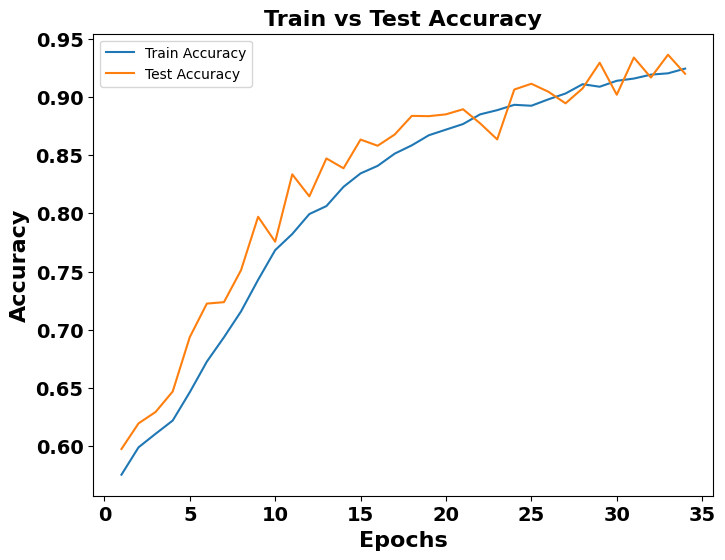

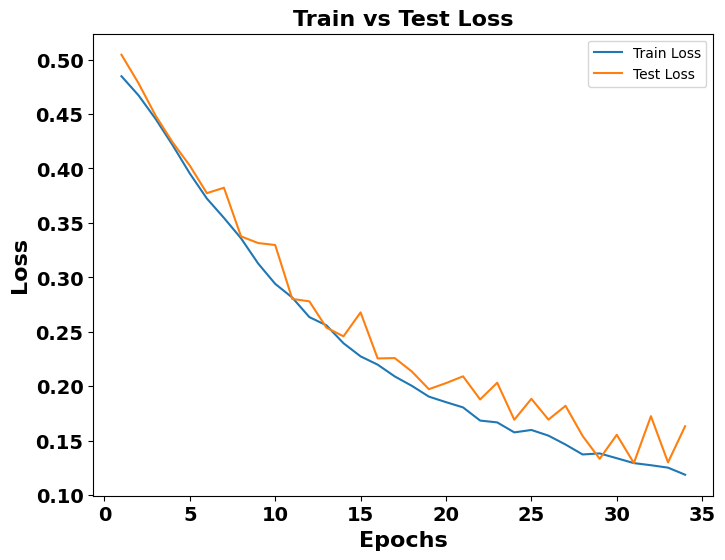

In [35]:
# Plot Training and Testing Accuracy
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

# Plot Training and Testing Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

#### Perforamce Evaluation Plots


📊 Final Test Evaluation Results:
✅ Loss: 0.1633
✅ Accuracy: 0.9267
✅ Precision: 0.9265
✅ Recall: 0.9021
✅ F1 Score: 0.9141
✅ Specificity: 0.9454
✅ ROC-AUC: 0.9785


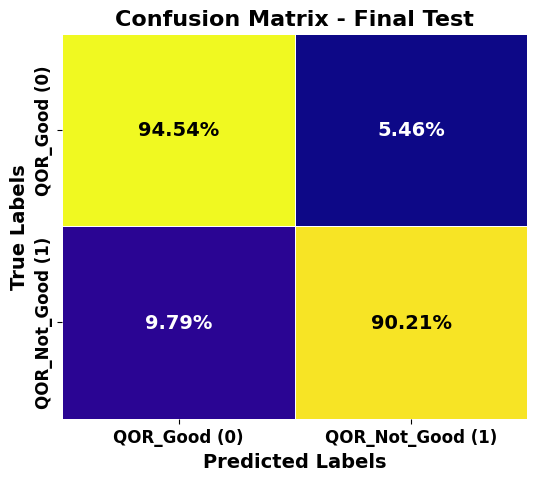

(0.16333043954295934,
 0.9266698935140368,
 0.9264790350373349,
 0.9021252796420581,
 0.9141399829980165,
 0.9453924914675768,
 0.9784865304151301)

In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# ======================
# Define Evaluation Function
# ======================
def evaluate_model(loader, dataset_name="Test"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)
            y = data.y.to(device).float().view(-1)

            loss = criterion(out, y)
            total_loss += loss.item() * data.num_graphs

            preds = (out >= 0.5).float()
            correct += (preds == y).sum().item()
            total += data.num_graphs

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_logits.extend(out.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_logits)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n📊 {dataset_name} Evaluation Results:")
    print(f"✅ Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ ROC-AUC: {roc_auc:.4f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = np.nan_to_num(conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(conf_matrix_percentage, annot=False, fmt='.2f', cmap='plasma', linewidths=0.5,
                     xticklabels=['QOR_Good (0)', 'QOR_Not_Good (1)'],
                     yticklabels=['QOR_Good (0)', 'QOR_Not_Good (1)'], cbar=False)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            value = f"{conf_matrix_percentage[i, j]:.2f}%"
            color = "black" if conf_matrix_percentage[i, j] > 50 else "white"
            ax.text(j + 0.5, i + 0.5, value, ha='center', va='center',
                    fontsize=14, fontweight='bold', color=color)

    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
    plt.ylabel('True Labels', fontsize=14, fontweight='bold')
    plt.xticks(ticks=[0.5, 1.5], labels=['QOR_Good (0)', 'QOR_Not_Good (1)'], fontsize=12, fontweight='bold')
    plt.yticks(ticks=[0.5, 1.5], labels=['QOR_Good (0)', 'QOR_Not_Good (1)'], fontsize=12, fontweight='bold')
    plt.show()

    return avg_loss, accuracy, precision, recall, f1, specificity, roc_auc

# ======================
# Run Final Test Only
# ======================
evaluate_model(test_loader, dataset_name="Final Test")


#### Confusion Matrix Plots (from saved model)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix
)

# ======================
# Load Saved Model
# ======================
model_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Code/Code_ML-DL/New Code/QOR_hybrid_stgcn_model_20250414_124144.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print(f"✅ Model loaded from: {model_path}")

# ======================
# Define Evaluation Function
# ======================
def evaluate_model(loader, dataset_name="Test"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)
            y = data.y.to(device).float().view(-1)

            loss = criterion(out, y)
            total_loss += loss.item() * data.num_graphs

            preds = (out >= 0.5).float()
            correct += (preds == y).sum().item()
            total += data.num_graphs

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_logits.extend(out.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_logits)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n📊 {dataset_name} Evaluation Results:")
    print(f"✅ Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ ROC-AUC: {roc_auc:.4f}")

    # Confusion Matrix Plot
    conf_matrix = confusion_matrix(all_labels, all_preds)
    conf_matrix_percentage = np.nan_to_num(
        conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100
    )

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(conf_matrix_percentage, annot=False, fmt='.2f', cmap='plasma',
                     linewidths=0.5,
                     xticklabels=['QOR_Good (0)', 'QOR_Not_Good (1)'],
                     yticklabels=['QOR_Good (0)', 'QOR_Not_Good (1)'], cbar=False)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            value = f"{conf_matrix_percentage[i, j]:.2f}%"
            color = "black" if conf_matrix_percentage[i, j] > 50 else "white"
            ax.text(j + 0.5, i + 0.5, value, ha='center', va='center',
                    fontsize=14, fontweight='bold', color=color)

    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
    plt.ylabel('True Labels', fontsize=14, fontweight='bold')
    plt.xticks(ticks=[0.5, 1.5], labels=['QOR_Good (0)', 'QOR_Not_Good (1)'], fontsize=12, fontweight='bold')
    plt.yticks(ticks=[0.5, 1.5], labels=['QOR_Good (0)', 'QOR_Not_Good (1)'], fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return avg_loss, accuracy, precision, recall, f1, specificity, roc_auc

# ======================
# Run Evaluation on Test Set
# ======================
evaluate_model(test_loader, dataset_name="Final Test")


#### Perforamce Evaluation Plots (from saved model)

In [ ]:
import torch
import pickle
import matplotlib.pyplot as plt

# === 1. Load the Trained Model Weights ===
model_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Code/Code_ML-DL/New Code/QOR_hybrid_stgcn_model_20250414_124144.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print(f"✅ Model loaded from: {model_path}")

# === 2. Evaluate on Final Test Data ===
evaluate_model(test_loader, dataset_name="Final Test")

# === 3. Load Training Stats ===
stats_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Code/Code_ML-DL/New Code/QOR_hybrid_stgcn_model_statistics_20250414_124144.pkl"
with open(stats_path, 'rb') as f:
    model_stats = pickle.load(f)

# === 4. Plot Loss and Accuracy Curves ===
train_losses = model_stats['train_losses']
test_losses = model_stats['test_losses']
train_accuracies = model_stats['train_accuracies']
test_accuracies = model_stats['test_accuracies']
final_metrics = model_stats['final_metrics']

# Loss Curve
plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(test_losses, label='Test Loss', color='red', linewidth=2)
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Loss Curve', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Accuracy Curve
plt.figure(figsize=(6, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue', linewidth=2)
plt.plot(test_accuracies, label='Test Accuracy', color='red', linewidth=2)
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Accuracy Curve', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Print Final Metrics
print("\n📈 Final Evaluation Metrics from Saved Stats:")
for metric, value in final_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")



#### ROC Curve (saved pkl)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# ======================
# Load Trained Model
# ======================
model_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Code/Code_ML-DL/New Code/QOR_hybrid_stgcn_model_20250414_124144.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()
print(f"✅ Model loaded from: {model_path}")

# ======================
# Define Evaluation Function
# ======================
def evaluate_model(loader, dataset_name="Test"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)
            y = data.y.to(device).float().view(-1)

            loss = criterion(out, y)
            total_loss += loss.item() * data.num_graphs

            preds = (out >= 0.5).float()
            correct += (preds == y).sum().item()
            total += data.num_graphs

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_logits.extend(out.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_logits)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n📊 {dataset_name} Evaluation Results:")
    print(f"✅ Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ ROC-AUC: {roc_auc:.4f}")

    return avg_loss, accuracy, precision, recall, f1, specificity, roc_auc, np.array(all_labels), np.array(all_logits)

# ======================
# Evaluate on Training and Testing Sets
# ======================
train_metrics = evaluate_model(train_loader, "Training")
test_metrics = evaluate_model(test_loader, "Testing")

# ======================
# Plot ROC Curve
# ======================
train_fpr, train_tpr, _ = roc_curve(train_metrics[7], train_metrics[8])
test_fpr, test_tpr, _ = roc_curve(test_metrics[7], test_metrics[8])

plt.figure(figsize=(6, 5))
plt.plot(train_fpr, train_tpr, color='blue', linewidth=2, label=f'Training ROC (AUC = {train_metrics[6]:.4f})')
plt.plot(test_fpr, test_tpr, color='red', linewidth=2, label=f'Testing ROC (AUC = {test_metrics[6]:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal

plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Training vs. Testing ROC Curve', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()

# ======================
# Load .pkl Training Statistics
# ======================
stats_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Code/Code_ML-DL/New Code/QOR_hybrid_stgcn_model_statistics_20250414_124144.pkl"

with open(stats_path, 'rb') as f:
    stats = pickle.load(f)

train_losses = stats['train_losses']
test_losses = stats['test_losses']
train_accuracies = stats['train_accuracies']
test_accuracies = stats['test_accuracies']
final_metrics = stats['final_metrics']

# ======================
# Plot Loss Curve
# ======================
plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.title('Loss Curve', fontsize=16, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# ======================
# Plot Accuracy Curve
# ======================
plt.figure(figsize=(6, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title('Accuracy Curve', fontsize=16, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ======================
# Final Metrics from .pkl
# ======================
print("\n📈 Final Metrics from Training Log:")
for k, v in final_metrics.items():
    print(f"{k.capitalize()}: {v:.4f}")


#### ROC Classwise (testing)

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_classwise_roc(y_true, y_probs, class_names=None, title="Class-wise ROC Curve"):
    """
    y_true: Ground truth binary labels (numpy array)
    y_probs: Raw model logits or probabilities (numpy array)
    class_names: List of class names, e.g., ['QOR_Good (0)', 'QOR_Not_Good (1)']
    """
    if class_names is None:
        class_names = ['Class 0', 'Class 1']
    
    plt.figure(figsize=(6, 5))
    for i, name in enumerate(class_names):
        y_binary = (y_true == i).astype(int)  # One-vs-all
        fpr, tpr, _ = roc_curve(y_binary, y_probs)
        auc = roc_auc_score(y_binary, y_probs)
        plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {auc:.4f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Usage with test predictions:
plot_classwise_roc(
    y_true=test_metrics[7], 
    y_probs=test_metrics[8], 
    class_names=['QOR_Good (0)', 'QOR_Not_Good (1)']
)


#### ROC Classwise (Training and testing)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_classwise_roc_train_test(train_labels, train_probs, test_labels, test_probs,
                                   class_names=['QOR_Good (0)', 'QOR_Not_Good (1)'],
                                   title="Class-wise ROC Curve"):
    """
    Plots class-wise ROC curves for both training and testing datasets.
    """
    plt.figure(figsize=(8, 6))
    
    for i, name in enumerate(class_names):
        # Train
        y_train_binary = (train_labels == i).astype(int)
        fpr_train, tpr_train, _ = roc_curve(y_train_binary, train_probs)
        auc_train = roc_auc_score(y_train_binary, train_probs)

        # Test
        y_test_binary = (test_labels == i).astype(int)
        fpr_test, tpr_test, _ = roc_curve(y_test_binary, test_probs)
        auc_test = roc_auc_score(y_test_binary, test_probs)

        plt.plot(fpr_train, tpr_train, linestyle='-', linewidth=2,
                 label=f"{name} - Train (AUC = {auc_train:.4f})", alpha=0.8)
        plt.plot(fpr_test, tpr_test, linestyle='--', linewidth=2,
                 label=f"{name} - Test (AUC = {auc_test:.4f})", alpha=0.8)

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# ======= Usage =======
plot_classwise_roc_train_test(
    train_labels=train_metrics[7],
    train_probs=train_metrics[8],
    test_labels=test_metrics[7],
    test_probs=test_metrics[8],
    class_names=['QOR_Good (0)', 'QOR_Not_Good (1)'],
    title="Training vs Testing ROC Curve (Per Class)"
)


### STGCN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle
from datetime import datetime


# Define joints and edges
joints = [
    'PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
    'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
    'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
    'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
    'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
    'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT'
]

edges = [
    ('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
    ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
    ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
    ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
    ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
    ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
    ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
    ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
    ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
    ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'), ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')
]

joint_to_idx = {joint: idx for idx, joint in enumerate(joints)}
edge_index = torch.tensor(
    [[joint_to_idx[src], joint_to_idx[dst]] for src, dst in edges] +
    [[joint_to_idx[dst], joint_to_idx[src]] for src, dst in edges],  # Bidirectional edges
    dtype=torch.long
).t()

# Dataset class (WITHOUT timestamps)
class SkeletonDataset(Dataset):
    def __init__(self, csv_file):
        self.data = csv_file
        self.num_nodes = len(joints)
        self.scaler = StandardScaler()
        
        # Normalize joint features
        joint_columns = [f'{joint}_{axis}' for joint in joints for axis in ['X', 'Y', 'Z']]
        self.data[joint_columns] = self.scaler.fit_transform(self.data[joint_columns])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Extract node features (ONLY X, Y, Z)
        node_features = [[row[f'{joint}_X'], row[f'{joint}_Y'], row[f'{joint}_Z']] for joint in joints]
        x = torch.tensor(node_features, dtype=torch.float)  # Shape: [num_nodes, 3]
        y = torch.tensor([row['QoR_class']], dtype=torch.float)  # Ensure y has shape [1]
        return Data(x=x, edge_index=edge_index, y=y)

# Define ST-GCN model (With Fixes)
class STGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(STGCN, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)  # ✅ Batch Normalization
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.gcn3 = GCNConv(hidden_channels, hidden_channels)  # ✅ Added Extra GCN Layer
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch if hasattr(data, 'batch') else None  # Handle batch processing

        x = F.leaky_relu(self.bn1(self.gcn1(x, edge_index)))  # ✅ LeakyReLU instead of ReLU
        x = F.leaky_relu(self.bn2(self.gcn2(x, edge_index)))
        x = F.leaky_relu(self.gcn3(x, edge_index))  # ✅ Third GCN Layer

        # Global Mean Pooling
        if batch is not None:
            x = global_mean_pool(x, batch)
        else:
            x = x.mean(dim=0, keepdim=True)  # Ensure batch shape

        x = self.fc(x)
        return x.squeeze()  # No Sigmoid here (Handled in BCEWithLogitsLoss)

# Load dataset
data_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/QOR_class_Kinect_feature_matrix_20241028_171716.csv"
dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
dataset = SkeletonDataset(csv_file=dataframe)

# Split into train/test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32  # ✅ Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = STGCN(in_channels=3, hidden_channels=256, num_classes=1).to(device)  # ✅ Increased hidden size
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # ✅ Increased LR

# Initialize Lists for Losses and Accuracies
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Training Loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        y = data.y.to(device).float()

        loss = criterion(out.view(-1), y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * data.num_graphs
        correct += ((out >= 0).float() == y).sum().item()
        total += data.num_graphs

    avg_train_loss, train_accuracy = total_loss / len(train_loader.dataset), correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation on Test Data
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            y = data.y.to(device).float()

            loss = criterion(out.view(-1), y.view(-1))
            total_loss += loss.item() * data.num_graphs
            correct += ((out >= 0).float() == y).sum().item()
            total += data.num_graphs

    avg_test_loss, test_accuracy = total_loss / len(test_loader.dataset), correct / total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

# Plot Training and Testing Accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, test_accuracies, label='Train Accuracy')
plt.plot(epochs, train_accuracies, label='Test Accuracy')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Accuracy', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

# Plot Training and Testing Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, test_losses, label='Train Loss')
plt.plot(epochs, train_losses, label='Test Loss')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.title('Train vs Test Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.show()


# Get the current timestamp
current_time = datetime.now().strftime('%Y%m%d_%H%M%S')  # Format: YYYYMMDD_HHMMSS

# Save the trained model to the specified directory with timestamp
model_save_path = f'_QOR_Stgcn_model_{current_time}.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Save training and evaluation statistics
model_stats = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies,
    'final_metrics': {
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'specificity': specificity,
        'roc_auc': roc_auc
    }
}

# Save training and evaluation statistics to the specified directory with timestamp
stats_save_path = f'QOR_Stgcn_model_statistics_{current_time}.pkl'
with open(stats_save_path, 'wb') as f:
    pickle.dump(model_stats, f)

print(f"Model statistics saved to {stats_save_path}")



#### Perforamce Evaluation Plots

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Function to Evaluate the Model
def evaluate_model(loader, dataset_name="Test"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)
            y = data.y.to(device).float().view(-1)
            
            loss = criterion(out, y)
            total_loss += loss.item() * data.num_graphs

            preds = (out >= 0).float()  # Convert logits to binary class
            correct += (preds == y).sum().item()
            total += data.num_graphs

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_logits.extend(out.cpu().numpy())

    # Compute metrics
    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_logits)
    
    # Compute specificity (True Negative Rate)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n📊 {dataset_name} Evaluation Results:")
    print(f"✅ Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ ROC-AUC: {roc_auc:.4f}")

    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Ensure proper scaling (avoid division by zero)
    conf_matrix_percentage = np.nan_to_num(conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True) * 100)

    # Debugging: Print Confusion Matrix Values
    print("Confusion Matrix (Raw Counts):\n", conf_matrix)
    print("Confusion Matrix (Percentage):\n", conf_matrix_percentage)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(conf_matrix_percentage, annot=False, fmt='.2f', cmap='plasma', linewidths=0.5,
                     xticklabels=['Non-Frail (0)', 'Frail (1)'],
                     yticklabels=['Non-Frail (0)', 'Frail (1)'], cbar=False)

    # Manually add annotations to force visibility
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            text_value = f"{conf_matrix_percentage[i, j]:.2f}%"
            text_color = "black" if conf_matrix_percentage[i, j] > 50 else "white"
            ax.text(j + 0.5, i + 0.5, text_value, 
                    ha='center', va='center', fontsize=14, fontweight='bold', color=text_color)

    plt.title(f'Confusion Matrix - {dataset_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=14, fontweight='bold')
    plt.ylabel('True Labels', fontsize=14, fontweight='bold')

    # Explicitly set ticks to ensure row visibility
    plt.xticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')
    plt.yticks(ticks=[0.5, 1.5], labels=['Non-Frail (0)', 'Frail (1)'], fontsize=12, fontweight='bold')

    plt.show()

    return avg_loss, accuracy, precision, recall, f1, specificity, roc_auc


# Evaluate on Training and Test Data
train_metrics = evaluate_model(train_loader, "Training")
test_metrics = evaluate_model(test_loader, "Testing")

# Plot Training & Testing Loss and Accuracy Curves
epochs_range = range(1, num_epochs + 1)
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in epochs_range:
    train_loss, train_acc = train_metrics[:2]
    test_loss, test_acc = test_metrics[:2]
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)




#### ROC Curve

#### ROC Curve Class-wise

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

# Function to Evaluate the Model
def evaluate_model(loader, dataset_name="Test"):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels, all_logits = [], [], []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).view(-1)
            y = data.y.to(device).float().view(-1)
            
            loss = criterion(out, y)
            total_loss += loss.item() * data.num_graphs

            preds = (out >= 0).float()  # Convert logits to binary class
            correct += (preds == y).sum().item()
            total += data.num_graphs

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_logits.extend(out.cpu().numpy())

    # Compute metrics
    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_logits)
    
    # Compute specificity (True Negative Rate)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"\n📊 {dataset_name} Evaluation Results:")
    print(f"✅ Loss: {avg_loss:.4f}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ ROC-AUC: {roc_auc:.4f}")

    return avg_loss, accuracy, precision, recall, f1, specificity, roc_auc, np.array(all_labels), np.array(all_logits)

# Evaluate on Training and Test Data
train_metrics = evaluate_model(train_loader, "Training")
test_metrics = evaluate_model(test_loader, "Testing")

# Plot Class-wise ROC Curve for Training Data
plt.figure(figsize=(6, 5))
for i, label in enumerate(['Non-Frail (0)', 'Frail (1)']):
    fpr, tpr, _ = roc_curve((train_metrics[7] == i).astype(int), train_metrics[8])
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Training ROC Curve', fontsize=16, fontweight='bold')
plt.show()

# Plot Class-wise ROC Curve for Testing Data
plt.figure(figsize=(6, 5))
for i, label in enumerate(['Non-Frail (0)', 'Frail (1)']):
    fpr, tpr, _ = roc_curve((test_metrics[7] == i).astype(int), test_metrics[8])
    plt.plot(fpr, tpr, linewidth=2, label=f'{label}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=16, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=14, prop={'weight': 'bold'})
plt.title('Testing ROC Curve', fontsize=16, fontweight='bold')
plt.show()

# Plot Training & Testing Loss and Accuracy Curves
epochs_range = range(1, num_epochs + 1)
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in epochs_range:
    train_loss, train_acc = train_metrics[:2]
    test_loss, test_acc = test_metrics[:2]
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)


#### GradCAM Function

In [ ]:
import torch
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

class GradCAM_GNN:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Register forward and backward hooks on the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_cam(self, data):
        self.model.eval()

        # Forward pass on the single sample
        output = self.model(data)

        # Backward pass to compute gradients
        self.model.zero_grad()
        output.backward()

        # Generate the CAM by multiplying the activations with the gradients
        cam = self.gradients * self.activations  # Shape: [hidden_channels, num_nodes]

        # Average across the channels (feature maps) to get the final CAM per node
        node_cam = cam.mean(dim=0)  # Shape: [num_nodes]

        # Normalize the node CAM to [0, 1]
        node_cam = node_cam - node_cam.min()
        node_cam = node_cam / node_cam.max()

        # Calculate edge importance by averaging the CAM values of the connected nodes
        edge_index = data.edge_index.cpu().numpy()
        edge_cam = []
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[:, i]
            edge_imp = (node_cam[src] + node_cam[dst]) / 2.0  # Averaging node CAMs for the edge
            edge_cam.append(edge_imp.item())

        edge_cam = np.array(edge_cam)

        return node_cam.detach().cpu().numpy(), edge_cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

# Visualization function for a single sample in 3D using Plotly with color scale
def visualize_human_skeleton_3d_plotly(cam, data, title="3D Grad-CAM Visualization"):
    node_cam, edge_cam = cam
    node_positions = data.x[:, :3].cpu().numpy()  # Assume first 3 columns are X, Y, Z

    # Create a scatter plot for the joints
    scatter = go.Scatter3d(
        x=node_positions[:, 0],
        y=node_positions[:, 1],
        z=node_positions[:, 2],
        mode='markers+text',
        text=[f'{i}' for i in range(node_positions.shape[0])],
        marker=dict(
            size=8,
            color=node_cam,
            colorscale='Viridis',
            colorbar=dict(title="Node Grad-CAM Value", x=0.9),  # Add color bar for node Grad-CAM values
            opacity=0.8
        )
    )

    # Create lines for the edges (bones)
    edge_index = data.edge_index.cpu().numpy()
    edge_x = []
    edge_y = []
    edge_z = []
    edge_colors = []
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        edge_x.extend([node_positions[src, 0], node_positions[dst, 0], None])
        edge_y.extend([node_positions[src, 1], node_positions[dst, 1], None])
        edge_z.extend([node_positions[src, 2], node_positions[dst, 2], None])
        edge_colors.extend([edge_cam[i], edge_cam[i], edge_cam[i]])  # Use the edge importance for coloring

    # Ensure that there are no None values in edge_colors
    edge_colors = np.array(edge_colors)
    edge_colors = np.nan_to_num(edge_colors, nan=0.0)  # Replace None or NaN with 0.0

    lines = go.Scatter3d(
        x=edge_x,
        y=edge_y,
        z=edge_z,
        mode='lines',
        line=dict(
            color=edge_colors,
            colorscale='Viridis',
            width=4,
            colorbar=dict(title="Edge Grad-CAM Value", x=1.05)  # Position the edge color bar separately
        ),
        hoverinfo='none'
    )

    # Combine the scatter plot and lines into a single figure
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
    fig.add_trace(scatter)
    fig.add_trace(lines)

    # Set the layout for better visualization, remove background and ticks
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X', showgrid=False, backgroundcolor="white", showticklabels=False),
            yaxis=dict(title='Y', showgrid=False, backgroundcolor="white", showticklabels=False),
            zaxis=dict(title='Z', showgrid=False, backgroundcolor="white", showticklabels=False),
            aspectmode='cube',
            bgcolor="white"  # Set overall scene background color to white
        ),
        margin=dict(l=0, r=0, b=0, t=0),
        paper_bgcolor="white",  # Set the background color of the figure
        plot_bgcolor="white",  # Set the background color of the plot area
        title=title,
        showlegend=False
    )

    fig.show()




#### GradCAM Plots

In [ ]:
data_path = "/athena/madelab/scratch/iqh4001/Kinect Project/Dataset/Data/pre-processed data/QOR_class_Kinect_feature_matrix_20241028_171716.csv"

dataframe = pd.read_csv(data_path)
dataframe = dataframe[dataframe['walking_speed'] == "Fast"]
dataframe.rename(columns={'PatientID': 'patientID'}, inplace=True)

# Specify the patient ID you want to visualize
patient_id = '047-MW'  # Replace with actual patient ID
# Filter the dataset for the specific patient
patient_data = dataframe[dataframe['patientID'] == patient_id]  # Assuming dataframe has 'patientID' column
patient_dataset = SkeletonDataset(patient_data)

# Create a DataLoader for the specific patient
patient_loader = DataLoader(patient_dataset, batch_size=1, shuffle=False)  # Batch size 1 to load one sample at a time

target_layer = model.gcn2 # Example target layer
grad_cam = GradCAM_GNN(model, target_layer)

# Specify which data points you want to plot
points_to_plot = [80]  # Change this list to include the desired data points

# Loop through the DataLoader and select the specified data points
for i, single_sample in enumerate(patient_loader, 1):  # Start index from 1
    if i in points_to_plot:
        print(f"Visualizing {i}-th data point for patient {patient_id}... and Layer {target_layer}")

        single_sample = single_sample.to(device)

        # Generate and visualize the CAM for this single patient sample
        cam = grad_cam.generate_cam(single_sample)
        visualize_human_skeleton_3d_plotly(cam, single_sample, title=f"Grad-CAM for Patient {patient_id}, Data Point {i}")

# Remove the hooks to clean up
grad_cam.remove_hooks()